<a href="https://colab.research.google.com/github/rahulkumar-datascientist/Detecting-Silent-Cardiac-Atrial-fibrillation-from-PPG-and-single-lead-ECG-Data-using-CNN-LSTM/blob/master/2_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Packages

In [ ]:
import pandas as pd
import numpy as np
from scipy.io import loadmat
import os, os.path
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'

import zipfile
import re
import pickle
import keras
from sklearn.model_selection import train_test_split
from keras.layers import Bidirectional, LSTM, Activation, Dense, Dropout, BatchNormalization, Input, Conv1D, MaxPooling1D, Flatten
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from sklearn.utils import class_weight
from numpy import genfromtxt


from scipy import signal
from scipy.signal import butter, iirnotch, lfilter
import numpy as np
import matplotlib.pyplot as plt

# Preprocessing for 2017 PhysioNet ECG Data

## Loading the Reference Label file

In [ ]:
ECG_signal_labels = pd.read_csv("REFERENCE.csv", header = None, names=['filename', 'output_label'])  

In [ ]:
ECG_signal_labels.sort_values(by ='filename', inplace = True, ignore_index=True)

In [ ]:
ECG_signal_labels.head()

,filename,output_label
0,A00001,N
1,A00002,N
2,A00003,N
3,A00004,A
4,A00005,A


In [ ]:
ECG_signal_labels.shape

(8528, 2)

In [ ]:
ECG_signal_labels['filename'][0:5]

0    A00001
1    A00002
2    A00003
3    A00004
4    A00005
Name: filename, dtype: object

In [ ]:
ECG_signal_labels['output_label'][0:5]

0    N
1    N
2    N
3    A
4    A
Name: output_label, dtype: object

## Adding all the ECG signal files to the corresponding dataframe

In [ ]:
# listing all the files present in the directory
dir_files = os.listdir('.')

In [ ]:
# filtering all the .mat files -- This contains the ECG signals
signal_files = []

for file in dir_files:
    if file.endswith(".mat"):
        signal_files.append(file)

In [ ]:
len(signal_files)

8528

In [ ]:
signal_files.sort()

In [ ]:
temp = loadmat('/content/drive/MyDrive/Colab Notebooks/Galenband Project/Data/training2017/A00001.mat')

In [ ]:
temp.keys()

temp['val']

array([[-127, -162, -197, ...,  -18,  -22,  -21]], dtype=int16)

In [ ]:
signals = []

for index,file in enumerate(signal_files):

  if(file.split('.')[0] == ECG_signal_labels['filename'][index]):
    temp_file = loadmat(file)
    signals.append(temp_file)
    print('file added: ', file, ' list length: ', len(signals)) 
  else:
    print('File not found', file)

Streaming output truncated to the last 5000 lines.
file added:  A03529.mat  list length:  3529
file added:  A03530.mat  list length:  3530
file added:  A03531.mat  list length:  3531
file added:  A03532.mat  list length:  3532
file added:  A03533.mat  list length:  3533
file added:  A03534.mat  list length:  3534
file added:  A03535.mat  list length:  3535
file added:  A03536.mat  list length:  3536
file added:  A03537.mat  list length:  3537
file added:  A03538.mat  list length:  3538
file added:  A03539.mat  list length:  3539
file added:  A03540.mat  list length:  3540
file added:  A03541.mat  list length:  3541
file added:  A03542.mat  list length:  3542
file added:  A03543.mat  list length:  3543
file added:  A03544.mat  list length:  3544
file added:  A03545.mat  list length:  3545
file added:  A03546.mat  list length:  3546
file added:  A03547.mat  list length:  3547
file added:  A03548.mat  list length:  3548
file added:  A03549.mat  list length:  3549
file added:  A03550.mat  

In [ ]:
len(signals)

8528

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Galenband Project

/content/drive/MyDrive/Colab Notebooks/Galenband Project


In [ ]:
# saving the signals list
# with open("signals_dict.txt", "wb") as fp:   # Pickling
#   pickle.dump(signals, fp)


In [ ]:
# loading the signals list
with open("signals_dict.txt", "rb") as fp:   # Unpickling
  signals = pickle.load(fp)

In [ ]:
len(signals)

8528

In [ ]:
signals

[{'val': array([[-127, -162, -197, ...,  -18,  -22,  -21]], dtype=int16)},
 {'val': array([[128, 157, 189, ...,   0,   1,   2]], dtype=int16)},
 {'val': array([[ 56,  73,  85, ..., -64, -36, -20]], dtype=int16)},
 {'val': array([[519, 619, 723, ..., 116,  17,  18]], dtype=int16)},
 {'val': array([[-188, -239, -274, ...,  -93,  -57,    0]], dtype=int16)},
 {'val': array([[-266, -316, -367, ...,   51,   34,   21]], dtype=int16)},
 {'val': array([[ 21,  22,  24, ..., 236, 174,  84]], dtype=int16)},
 {'val': array([[-187, -236, -286, ...,  -98,  -33,   19]], dtype=int16)},
 {'val': array([[ 51,  56,  59, ..., -80, -69, -62]], dtype=int16)},
 {'val': array([[-1028, -1225, -1418, ...,    10,     9,     9]], dtype=int16)},
 {'val': array([[ -69,  -89, -108, ...,   96,   79,   62]], dtype=int16)},
 {'val': array([[ 72,  88, 103, ...,  20,  20,  20]], dtype=int16)},
 {'val': array([[-20, -27, -33, ..., -16, -22, -26]], dtype=int16)},
 {'val': array([[-62, -72, -81, ..., -70, -66, -62]], dtype=i

In [ ]:
signals_1 = []

for index in range(len(signals)):
  signals_1.append(signals[index]['val'])

In [ ]:
len(signals_1)

8528

In [ ]:
ECG_signal_labels['signals'] = signals_1

In [ ]:
ECG_signal_labels.head()

,filename,output_label,signals
0,A00001,N,"[[-127, -162, -197, -229, -245, -254, -261, -2..."
1,A00002,N,"[[128, 157, 189, 226, 250, 257, 262, 265, 268,..."
2,A00003,N,"[[56, 73, 85, 93, 100, 107, 113, 117, 118, 117..."
3,A00004,A,"[[519, 619, 723, 827, 914, 956, 955, 934, 920,..."
4,A00005,A,"[[-188, -239, -274, -316, -356, -374, -380, -3..."


In [ ]:
orig_cols = ECG_signal_labels.columns.tolist()

new_cols = ['filename', 'signals', 'output_label']

ECG_signal_labels_new = ECG_signal_labels[new_cols]

ECG_signal_labels_new

,filename,signals,output_label
0,A00001,"[[-127, -162, -197, -229, -245, -254, -261, -2...",N
1,A00002,"[[128, 157, 189, 226, 250, 257, 262, 265, 268,...",N
2,A00003,"[[56, 73, 85, 93, 100, 107, 113, 117, 118, 117...",N
3,A00004,"[[519, 619, 723, 827, 914, 956, 955, 934, 920,...",A
4,A00005,"[[-188, -239, -274, -316, -356, -374, -380, -3...",A
...,...,...,...
8523,A08524,"[[-104, -127, -144, -154, -160, -164, -168, -1...",N
8524,A08525,"[[-121, -197, -288, -390, -496, -600, -693, -7...",O
8525,A08526,"[[-202, -235, -272, -305, -325, -339, -344, -3...",N
8526,A08527,"[[-227, -297, -374, -449, -505, -527, -539, -5...",N


In [ ]:
ECG_signal_labels_new['output_label'].value_counts()

N    5050
O    2456
A     738
~     284
Name: output_label, dtype: int64

In [ ]:
# saving both the dataframes
pd.to_pickle(ECG_signal_labels, "Dataframes/original dataframe.pkl")
pd.to_pickle(ECG_signal_labels_new, "Dataframes/original dataframe sorted.pkl")

## Filtering the dataframe for only AFib and Normal signals 

In [ ]:
# Load the datasets
ECG_signal_labels = pd.read_pickle('Dataframes/original dataframe.pkl')
ECG_signal_labels_new = pd.read_pickle('Dataframes/original dataframe sorted.pkl')

In [ ]:
# view the dataset
ECG_signal_labels_new.head(5)

,filename,signals,output_label
0,A00001,"[[-127, -162, -197, -229, -245, -254, -261, -2...",N
1,A00002,"[[128, 157, 189, 226, 250, 257, 262, 265, 268,...",N
2,A00003,"[[56, 73, 85, 93, 100, 107, 113, 117, 118, 117...",N
3,A00004,"[[519, 619, 723, 827, 914, 956, 955, 934, 920,...",A
4,A00005,"[[-188, -239, -274, -316, -356, -374, -380, -3...",A


In [ ]:
ECG_signal_labels_filtered = ECG_signal_labels_new[(ECG_signal_labels_new.output_label == 'N') | (ECG_signal_labels_new.output_label == 'A')]

In [ ]:
ECG_signal_labels_filtered

,filename,signals,output_label
0,A00001,"[[-127, -162, -197, -229, -245, -254, -261, -2...",N
1,A00002,"[[128, 157, 189, 226, 250, 257, 262, 265, 268,...",N
2,A00003,"[[56, 73, 85, 93, 100, 107, 113, 117, 118, 117...",N
3,A00004,"[[519, 619, 723, 827, 914, 956, 955, 934, 920,...",A
4,A00005,"[[-188, -239, -274, -316, -356, -374, -380, -3...",A
...,...,...,...
8522,A08523,"[[-45, -55, -64, -71, -75, -76, -74, -71, -67,...",A
8523,A08524,"[[-104, -127, -144, -154, -160, -164, -168, -1...",N
8525,A08526,"[[-202, -235, -272, -305, -325, -339, -344, -3...",N
8526,A08527,"[[-227, -297, -374, -449, -505, -527, -539, -5...",N


In [ ]:
ECG_signal_labels_filtered.reset_index(drop=True, inplace=True)

ECG_signal_labels_filtered

,filename,signals,output_label
0,A00001,"[[-127, -162, -197, -229, -245, -254, -261, -2...",N
1,A00002,"[[128, 157, 189, 226, 250, 257, 262, 265, 268,...",N
2,A00003,"[[56, 73, 85, 93, 100, 107, 113, 117, 118, 117...",N
3,A00004,"[[519, 619, 723, 827, 914, 956, 955, 934, 920,...",A
4,A00005,"[[-188, -239, -274, -316, -356, -374, -380, -3...",A
...,...,...,...
5783,A08523,"[[-45, -55, -64, -71, -75, -76, -74, -71, -67,...",A
5784,A08524,"[[-104, -127, -144, -154, -160, -164, -168, -1...",N
5785,A08526,"[[-202, -235, -272, -305, -325, -339, -344, -3...",N
5786,A08527,"[[-227, -297, -374, -449, -505, -527, -539, -5...",N


In [ ]:
ECG_signal_labels_filtered['output_label'].value_counts()

N    5050
A     738
Name: output_label, dtype: int64

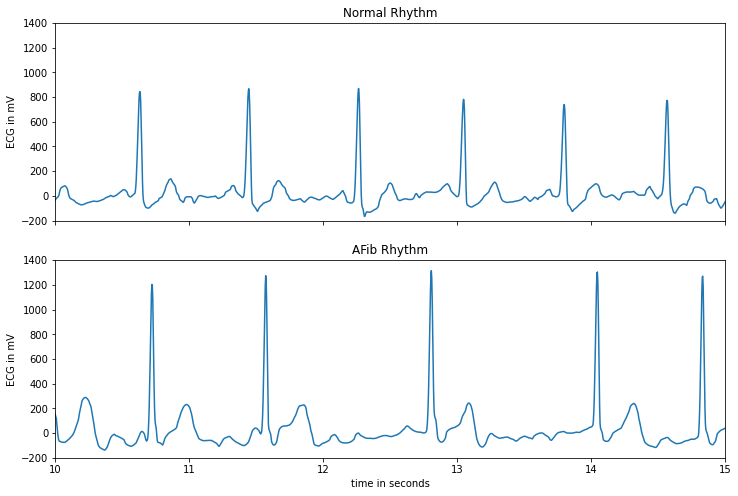

In [ ]:
# -- Reference --
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.misc.electrocardiogram.html 
# https://matplotlib.org/devdocs/gallery/subplots_axes_and_figures/subplots_demo.html
# https://stackoverflow.com/questions/14770735/how-do-i-change-the-figure-size-with-subplots

N_beat = np.array(ECG_signal_labels_filtered.loc[0,:]['signals'])
Afib_beat = np.array(ECG_signal_labels_filtered.loc[3,:]['signals'])

fs = 300
time = np.arange(N_beat[0].size) / fs


fig, axs = plt.subplots(2, figsize=(12,8))

axs[0].plot(time, N_beat[0])
axs[1].plot(time, Afib_beat[0])

axs[0].axis(xmin = 10 , xmax = 15)
axs[1].axis(xmin = 10 , xmax = 15)

axs[0].axis(ymin = -200 , ymax = 1400)
axs[1].axis(ymin = -200 , ymax = 1400)

axs[0].set_title('Normal Rhythm')
axs[1].set_title('AFib Rhythm')

for ax in axs.flat:
    ax.set(xlabel='time in seconds', ylabel='ECG in mV')

for ax in axs.flat:
    ax.label_outer()


## Histogram to view the distribution of ECG signal length across the dataframe

In [ ]:
signal_length = []

for index in range(len(ECG_signal_labels_filtered.signals)):
  signal_length.append(ECG_signal_labels_filtered.signals[index].shape[1])

ECG_signal_labels_filtered['signal_length'] = signal_length

In [ ]:
orig_cols = ECG_signal_labels_filtered.columns.tolist()

new_cols = ['filename','signal_length', 'signals', 'output_label']

ECG_signal_labels_filtered = ECG_signal_labels_filtered[new_cols]

ECG_signal_labels_filtered

,filename,signal_length,signals,output_label
0,A00001,9000,"[[-127, -162, -197, -229, -245, -254, -261, -2...",N
1,A00002,9000,"[[128, 157, 189, 226, 250, 257, 262, 265, 268,...",N
2,A00003,18000,"[[56, 73, 85, 93, 100, 107, 113, 117, 118, 117...",N
3,A00004,9000,"[[519, 619, 723, 827, 914, 956, 955, 934, 920,...",A
4,A00005,18000,"[[-188, -239, -274, -316, -356, -374, -380, -3...",A
...,...,...,...,...
5783,A08523,9000,"[[-45, -55, -64, -71, -75, -76, -74, -71, -67,...",A
5784,A08524,9000,"[[-104, -127, -144, -154, -160, -164, -168, -1...",N
5785,A08526,10904,"[[-202, -235, -272, -305, -325, -339, -344, -3...",N
5786,A08527,9000,"[[-227, -297, -374, -449, -505, -527, -539, -5...",N


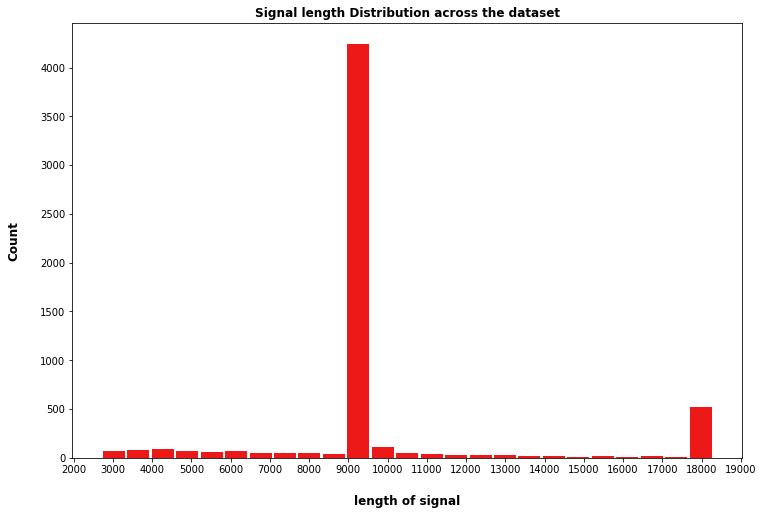

In [ ]:
ax = ECG_signal_labels_filtered.hist(column = 'signal_length', bins = 25, 
                                     grid = False, figsize = (12,8), 
                                     color = '#ed1818', rwidth = 0.9)

ax = ax[0]
for x in ax:

    x.set_xticks(list(range(2000,20000,1000)), minor=False)
    x.set_title("Signal length Distribution across the dataset", weight='bold', size=12)
    x.set_xlabel("length of signal", labelpad=20, weight='bold', size=12)
    x.set_ylabel("Count", labelpad=20, weight='bold', size=12)


In [ ]:
# saving filtered dataframes
pd.to_pickle(ECG_signal_labels_filtered, "Dataframes/AFib dataframe.pkl")

In [ ]:
ECG_signal_labels_filtered.dtypes

filename         object
signal_length     int64
signals          object
output_label     object
dtype: object

# Splitting the data into train and validation set

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Galenband Project

/content/drive/MyDrive/Colab Notebooks/Galenband Project


In [ ]:
# loading the saved dataframe
ECG_signal_labels_filtered = pd.read_pickle('Dataframes/AFib dataframe.pkl')

In [ ]:
ECG_signal_labels_filtered[ECG_signal_labels_filtered.signal_length < 9000].shape

(634, 4)

In [ ]:
ECG_signal_labels_filtered[ECG_signal_labels_filtered.signal_length < 9000]['output_label'].value_counts()

N    521
A    113
Name: output_label, dtype: int64

looking at the signals < 9k samples:

- 82% are normal rhythm and 18% are Afib rhythm
- 10% are normal out of complete normal data
- 15% are Afib out of complete Afib data

In [ ]:
# dropping any signal <9k 
ECG_signal_labels_filtered = ECG_signal_labels_filtered[ECG_signal_labels_filtered.signal_length >= 9000]

ECG_signal_labels_filtered.reset_index(drop=True, inplace=True)

ECG_signal_labels_filtered

,filename,signal_length,signals,output_label
0,A00001,9000,"[[-127, -162, -197, -229, -245, -254, -261, -2...",N
1,A00002,9000,"[[128, 157, 189, 226, 250, 257, 262, 265, 268,...",N
2,A00003,18000,"[[56, 73, 85, 93, 100, 107, 113, 117, 118, 117...",N
3,A00004,9000,"[[519, 619, 723, 827, 914, 956, 955, 934, 920,...",A
4,A00005,18000,"[[-188, -239, -274, -316, -356, -374, -380, -3...",A
...,...,...,...,...
5149,A08523,9000,"[[-45, -55, -64, -71, -75, -76, -74, -71, -67,...",A
5150,A08524,9000,"[[-104, -127, -144, -154, -160, -164, -168, -1...",N
5151,A08526,10904,"[[-202, -235, -272, -305, -325, -339, -344, -3...",N
5152,A08527,9000,"[[-227, -297, -374, -449, -505, -527, -539, -5...",N


In [ ]:
ECG_signal_labels_filtered['output_label'].value_counts()

N    4529
A     625
Name: output_label, dtype: int64

In [ ]:
# split the data into train and test set
train, test = train_test_split(ECG_signal_labels_filtered, test_size=0.3, random_state=42, shuffle=True)

In [ ]:
train.reset_index(drop=True, inplace=True)
train

,filename,signal_length,signals,output_label
0,A08127,9000,"[[-44, -56, -10, 46, 192, 352, 468, 519, 535, ...",N
1,A03755,9000,"[[16, 17, 17, 18, 19, 19, 19, 18, 18, 17, 15, ...",N
2,A01329,9000,"[[271, 335, 410, 482, 526, 541, 525, 505, 487,...",N
3,A04975,9000,"[[501, 598, 697, 798, 886, 918, 928, 926, 912,...",N
4,A01610,9000,"[[-504, -611, -733, -874, -1021, -1154, -1220,...",N
...,...,...,...,...
3602,A07264,9000,"[[978, 1174, 1381, 1591, 1772, 1852, 1881, 188...",N
3603,A00777,9000,"[[-265, -325, -383, -440, -470, -486, -494, -5...",N
3604,A05062,9000,"[[148, 193, 242, 276, 301, 318, 329, 330, 322,...",N
3605,A06178,9390,"[[-4, -4, -3, -1, 0, 0, 0, 1, 3, 7, 12, 17, 22...",N


In [ ]:
train['output_label'].value_counts()

N    3163
A     444
Name: output_label, dtype: int64

In [ ]:
test.reset_index(drop=True, inplace=True)
test

,filename,signal_length,signals,output_label
0,A07459,9000,"[[-275, -367, -471, -581, -686, -779, -852, -9...",N
1,A00806,9000,"[[82, 100, 119, 144, 157, 165, 171, 176, 179, ...",N
2,A04546,9000,"[[-84, -98, -103, -105, -107, -110, -112, -109...",N
3,A07303,9000,"[[-5, -5, -4, -4, -5, -5, -5, -4, -3, -1, 0, 3...",N
4,A04502,9000,"[[-225, -259, -302, -334, -353, -367, -367, -3...",N
...,...,...,...,...
1542,A01687,9000,"[[-338, -408, -475, -540, -590, -609, -610, -5...",N
1543,A07490,9000,"[[-113, -136, -151, -163, -173, -180, -181, -1...",N
1544,A07186,9000,"[[549, 644, 737, 828, 895, 918, 898, 872, 849,...",N
1545,A06259,13688,"[[6, 8, 9, 32, 110, 229, 382, 548, 689, 747, 7...",N


In [ ]:
test['output_label'].value_counts()

N    1366
A     181
Name: output_label, dtype: int64

# Normalising the dataset

In [ ]:
####################################### Original DF #####################################
print("Original DF : total length :\t\t", len(ECG_signal_labels_filtered))

print("Original DF : == 9k samples :\t\t", \
      ECG_signal_labels_filtered[ECG_signal_labels_filtered.signal_length == 9000].shape)

print("Original DF : >9k & <18k samples :\t", \
      ECG_signal_labels_filtered[(ECG_signal_labels_filtered.signal_length > 9000) & 
                                 (ECG_signal_labels_filtered.signal_length < 18000)].shape)

print("Original DF : >=18k samples:\t\t", \
      ECG_signal_labels_filtered[ECG_signal_labels_filtered.signal_length >= 18000].shape)


####################################### train DF #####################################
print("\ntrain DF : total length :\t\t", len(train))
print("train DF : == 9k samples :\t\t", \
      train[train.signal_length == 9000].shape)

print("train DF : >9k & <18k samples :\t\t", \
      train[(train.signal_length > 9000) & (train.signal_length < 18000)].shape)

print("train DF : >=18k samples:\t\t", \
      train[train.signal_length >= 18000].shape)

####################################### test DF #####################################
print("\ntest DF : total length :\t\t", len(test))
print("test DF : == 9k samples :\t\t", \
      test[test.signal_length == 9000].shape)

print("test DF : >9k & <18k samples :\t\t", \
      test[(test.signal_length > 9000) & (test.signal_length < 18000)].shape)

print("test DF : >=18k samples:\t\t", \
      test[test.signal_length >= 18000].shape)

Original DF : total length :		 5154
Original DF : == 9k samples :		 (4177, 4)
Original DF : >9k & <18k samples :	 (476, 4)
Original DF : >=18k samples:		 (501, 4)

train DF : total length :		 3607
train DF : == 9k samples :		 (2898, 4)
train DF : >9k & <18k samples :		 (341, 4)
train DF : >=18k samples:		 (368, 4)

test DF : total length :		 1547
test DF : == 9k samples :		 (1279, 4)
test DF : >9k & <18k samples :		 (135, 4)
test DF : >=18k samples:		 (133, 4)


### Dataset without any augmentation

#### Training set

In [ ]:
# creating a normalised training dataframe to hold the final data after the below processing
train_normalised = pd.DataFrame(columns = ['filename', 'signal_length', 'signals', 'output_label'])


# adding rows into the new dataframe
for row_index in train.index:

  ###################### = 9k samples  ###############################
  if (train['signal_length'][row_index] == 9000):
    train_normalised = train_normalised.append(train.iloc[row_index], ignore_index=True)

  ###################### >9k and <18k samples  ###################### 
  if ((train['signal_length'][row_index] > 9000)     & 
      (train['signal_length'][row_index] < 18000)):
    
    # convert to 1D list
    sig = list(train['signals'][row_index].flat)
    
    # slice the 1st 9k signals and discard the rest 
    sig_1 = sig[0:9000]                       
    
    # reshape the signals back to 2D array
    sig_1 = np.array(sig_1).reshape((1,len(sig_1)))
    
    # create temp rows
    temp_row_1 = train.iloc[row_index]
    temp_row_1['filename'] = train['filename'][row_index] + '_a'
    temp_row_1['signals'] = sig_1
    temp_row_1['signal_length'] = len(temp_row_1['signals'][0])
    
    # append the rows into the dataframe
    train_normalised = train_normalised.append(temp_row_1, ignore_index=True)

  ###################### >=18k samples  ############################
  if (train['signal_length'][row_index] >= 18000):
    
    # convert to 1D list
    sig = list(train['signals'][row_index].flat)
    
    # slice the signals
    sig_1 = sig[0:9000]                       # slice 1st 9k samples

    sig_2 = sig[9000:18000]                       # slice 2nd 9k samples
    
    # reshape the signals back to 2D array
    sig_1 = np.array(sig_1).reshape((1,len(sig_1)))
    sig_2 = np.array(sig_2).reshape((1,len(sig_2)))

    # create temp rows
    temp_row_1 = train.iloc[row_index]
    temp_row_1['filename'] = train['filename'][row_index] + '_a'
    temp_row_1['signals'] = sig_1
    temp_row_1['signal_length'] = len(temp_row_1['signals'][0])
    

    temp_row_2 = train.iloc[row_index]
    temp_row_2['filename'] = train['filename'][row_index] + '_b'
    temp_row_2['signals'] = sig_2
    temp_row_2['signal_length'] = len(temp_row_2['signals'][0])

    # append the rows into the dataframe
    train_normalised = train_normalised.append(temp_row_1, ignore_index=True)
    train_normalised = train_normalised.append(temp_row_2, ignore_index=True)


In [ ]:
train_normalised

,filename,signal_length,signals,output_label
0,A08127,9000,"[[-44, -56, -10, 46, 192, 352, 468, 519, 535, ...",N
1,A03755,9000,"[[16, 17, 17, 18, 19, 19, 19, 18, 18, 17, 15, ...",N
2,A01329,9000,"[[271, 335, 410, 482, 526, 541, 525, 505, 487,...",N
3,A04975,9000,"[[501, 598, 697, 798, 886, 918, 928, 926, 912,...",N
4,A01610,9000,"[[-504, -611, -733, -874, -1021, -1154, -1220,...",N
...,...,...,...,...
3970,A07264,9000,"[[978, 1174, 1381, 1591, 1772, 1852, 1881, 188...",N
3971,A00777,9000,"[[-265, -325, -383, -440, -470, -486, -494, -5...",N
3972,A05062,9000,"[[148, 193, 242, 276, 301, 318, 329, 330, 322,...",N
3973,A06178_a,9000,"[[-4, -4, -3, -1, 0, 0, 0, 1, 3, 7, 12, 17, 22...",N


#### Testing set

In [ ]:
# creating a normalised testing dataframe to hold the final data after the below processing
test_normalised = pd.DataFrame(columns = ['filename', 'signal_length', 'signals', 'output_label'])


# adding rows into the new dataframe
for row_index in test.index:

  ###################### = 9k samples  ###############################
  if (test['signal_length'][row_index] == 9000):
    test_normalised = test_normalised.append(test.iloc[row_index], ignore_index=True)

  ###################### >9k and <18k samples  ###################### 
  if ((test['signal_length'][row_index] > 9000)     & 
      (test['signal_length'][row_index] < 18000)):
    
    # convert to 1D list
    sig = list(test['signals'][row_index].flat)
    
    # slice the 1st 9k signals and discard the rest 
    sig_1 = sig[0:9000]                       
    
    # reshape the signals back to 2D array
    sig_1 = np.array(sig_1).reshape((1,len(sig_1)))
    
    # create temp rows
    temp_row_1 = test.iloc[row_index]
    temp_row_1['filename'] = test['filename'][row_index] + '_a'
    temp_row_1['signals'] = sig_1
    temp_row_1['signal_length'] = len(temp_row_1['signals'][0])
    
    # append the rows into the dataframe
    test_normalised = test_normalised.append(temp_row_1, ignore_index=True)

  ###################### >=18k samples  ############################
  if (test['signal_length'][row_index] >= 18000):
    
    # convert to 1D list
    sig = list(test['signals'][row_index].flat)
    
    # slice the signals
    sig_1 = sig[0:9000]                       # slice 1st 9k samples

    sig_2 = sig[9000:18000]                       # slice 2nd 9k samples
    
    # reshape the signals back to 2D array
    sig_1 = np.array(sig_1).reshape((1,len(sig_1)))
    sig_2 = np.array(sig_2).reshape((1,len(sig_2)))

    # create temp rows
    temp_row_1 = test.iloc[row_index]
    temp_row_1['filename'] = test['filename'][row_index] + '_a'
    temp_row_1['signals'] = sig_1
    temp_row_1['signal_length'] = len(temp_row_1['signals'][0])
    

    temp_row_2 = test.iloc[row_index]
    temp_row_2['filename'] = test['filename'][row_index] + '_b'
    temp_row_2['signals'] = sig_2
    temp_row_2['signal_length'] = len(temp_row_2['signals'][0])

    # append the rows into the dataframe
    test_normalised = test_normalised.append(temp_row_1, ignore_index=True)
    test_normalised = test_normalised.append(temp_row_2, ignore_index=True)


In [ ]:
test_normalised

,filename,signal_length,signals,output_label
0,A07459,9000,"[[-275, -367, -471, -581, -686, -779, -852, -9...",N
1,A00806,9000,"[[82, 100, 119, 144, 157, 165, 171, 176, 179, ...",N
2,A04546,9000,"[[-84, -98, -103, -105, -107, -110, -112, -109...",N
3,A07303,9000,"[[-5, -5, -4, -4, -5, -5, -5, -4, -3, -1, 0, 3...",N
4,A04502,9000,"[[-225, -259, -302, -334, -353, -367, -367, -3...",N
...,...,...,...,...
1675,A01687,9000,"[[-338, -408, -475, -540, -590, -609, -610, -5...",N
1676,A07490,9000,"[[-113, -136, -151, -163, -173, -180, -181, -1...",N
1677,A07186,9000,"[[549, 644, 737, 828, 895, 918, 898, 872, 849,...",N
1678,A06259_a,9000,"[[6, 8, 9, 32, 110, 229, 382, 548, 689, 747, 7...",N


In [ ]:
print("\ntrain_normalised : total length :\t\t", len(train_normalised))
print("train_normalised : == 9k samples :\t\t", \
      train_normalised[train_normalised.signal_length == 9000].shape)

print("train_normalised : >9k & <18k samples :\t\t", \
      train_normalised[(train_normalised.signal_length > 9000) & (train_normalised.signal_length < 18000)].shape)

print("train_normalised : >=18k samples:\t\t", \
      train_normalised[train_normalised.signal_length >= 18000].shape)

###########################################################################################

print("\ntest_normalised : total length :\t\t", len(test_normalised))
print("test_normalised : == 9k samples :\t\t", \
      test_normalised[test_normalised.signal_length == 9000].shape)

print("test_normalised : >9k & <18k samples :\t\t", \
      test_normalised[(test_normalised.signal_length > 9000) & (test_normalised.signal_length < 18000)].shape)

print("test_normalised : >=18k samples:\t\t", \
      test_normalised[test_normalised.signal_length >= 18000].shape)


train_normalised : total length :		 3975
train_normalised : == 9k samples :		 (3975, 4)
train_normalised : >9k & <18k samples :		 (0, 4)
train_normalised : >=18k samples:		 (0, 4)

test_normalised : total length :		 1680
test_normalised : == 9k samples :		 (1680, 4)
test_normalised : >9k & <18k samples :		 (0, 4)
test_normalised : >=18k samples:		 (0, 4)


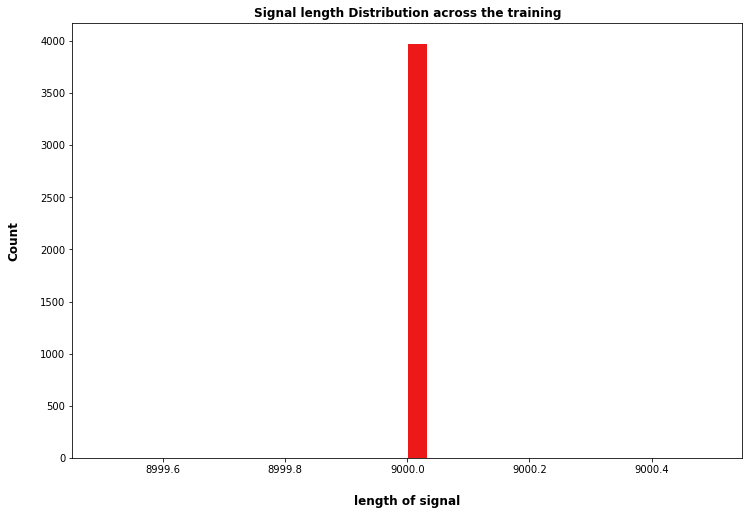

In [ ]:
train_normalised.signal_length = train_normalised .signal_length.astype(int)

ax = train_normalised.hist(column = 'signal_length', bins = 30, 
                                     grid = False, figsize = (12,8), 
                                     color = '#ed1818', rwidth = 0.9)

ax = ax[0]
for x in ax:

    x.get_xaxis().get_major_formatter().set_useOffset(False)
    x.set_title("Signal length Distribution across the training", weight='bold', size=12)
    x.set_xlabel("length of signal", labelpad=20, weight='bold', size=12)
    x.set_ylabel("Count", labelpad=20, weight='bold', size=12)


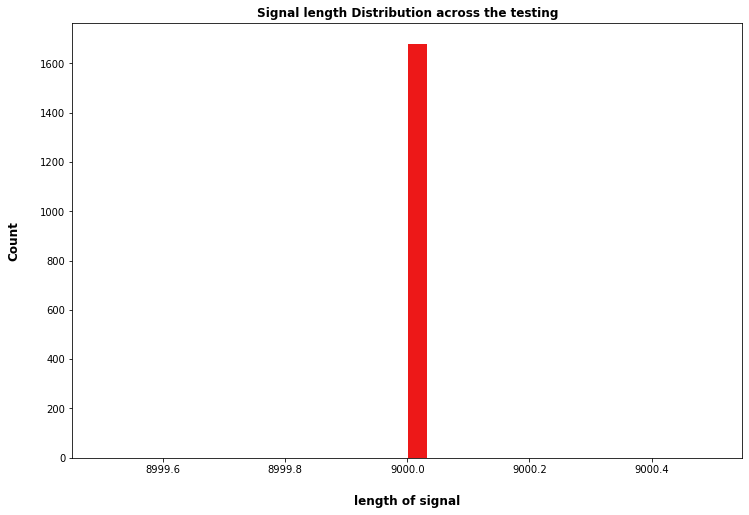

In [ ]:
test_normalised.signal_length = test_normalised.signal_length.astype(int)

ax = test_normalised.hist(column = 'signal_length', bins = 30, 
                                     grid = False, figsize = (12,8), 
                                     color = '#ed1818', rwidth = 0.9)

ax = ax[0]
for x in ax:

    x.get_xaxis().get_major_formatter().set_useOffset(False)
    x.set_title("Signal length Distribution across the testing", weight='bold', size=12)
    x.set_xlabel("length of signal", labelpad=20, weight='bold', size=12)
    x.set_ylabel("Count", labelpad=20, weight='bold', size=12)


In [ ]:
# saving training_normalised and testing_normalised dataframes
pd.to_pickle(train_normalised, "Dataframes/Train_normalised.pkl")
pd.to_pickle(test_normalised, "Dataframes/Test_normalised.pkl")

### Dataset with training signals augmentation

Pseudo code

1. select 1 row from the dataset.

2. if row has signal = 9k , append the row into a new dataset
3. if row has signal > 9k and <= 18k, then

 3.1 slice the signal from front and back for 9k samples -- will create overlap and save in 2 different temp array
 
 3.2 append the data and write back into dataset

4. if row has signal > 18k, then

  4.1 chop 1st 9k signals and save it.

  4.2 repeat step 4

  4.3 append all 3 rows into the dataset

In [ ]:
# creating a normalised dataframe to hold the final data after the below processing
train_normalised_aug = pd.DataFrame(columns = ['filename', 'signal_length', 'signals', 'output_label'])


# adding rows into the new dataframe
for row_index in train.index:

  ###################### = 9k samples  ###############################
  if (train['signal_length'][row_index] == 9000):
    train_normalised_aug = train_normalised_aug.append(train.iloc[row_index], ignore_index=True)

  ###################### >9k and <=18k samples  ###################### 
  if ((train['signal_length'][row_index] > 9000)     & 
      (train['signal_length'][row_index] <= 18000)):
    
    # convert to 1D list
    sig = list(train['signals'][row_index].flat)
    
    # slice the signals
    sig_1 = sig[0:9000]                       # slice 1st 9k samples
    
    ix = len(sig) - 9000                      # find index to slice 9k samples from back 
    sig_2 = sig[ix:]                          # slice 9k samples from back
    
    # reshape the signals back to 2D array
    sig_1 = np.array(sig_1).reshape((1,len(sig_1)))
    sig_2 = np.array(sig_2).reshape((1,len(sig_2)))

    # create temp rows
    temp_row_1 = train.iloc[row_index]
    temp_row_1['filename'] = train['filename'][row_index] + '_a'
    temp_row_1['signals'] = sig_1
    temp_row_1['signal_length'] = len(temp_row_1['signals'][0])
    

    temp_row_2 = train.iloc[row_index]
    temp_row_2['filename'] = train['filename'][row_index] + '_b'
    temp_row_2['signals'] = sig_2
    temp_row_2['signal_length'] = len(temp_row_2['signals'][0])

    # append the rows into the dataframe
    train_normalised_aug = train_normalised_aug.append(temp_row_1, ignore_index=True)
    train_normalised_aug = train_normalised_aug.append(temp_row_2, ignore_index=True)

  ###################### >18k samples  ############################
  if (train['signal_length'][row_index] > 18000):
    
    # convert to 1D list
    sig = list(train['signals'][row_index].flat)
    
    # slice the signals
    sig_1 = sig[0:9000]                       # slice 1st 9k samples

    sig_2 = sig[9000:18000]                       # slice 2nd 9k samples
    
    ix = len(sig) - 9000                      # find index to slice 9k samples from back 
    sig_3 = sig[ix:]                          # slice 9k samples from back
    
    # reshape the signals back to 2D array
    sig_1 = np.array(sig_1).reshape((1,len(sig_1)))
    sig_2 = np.array(sig_2).reshape((1,len(sig_2)))
    sig_3 = np.array(sig_3).reshape((1,len(sig_3)))

    # create temp rows
    temp_row_1 = train.iloc[row_index]
    temp_row_1['filename'] = train['filename'][row_index] + '_a'
    temp_row_1['signals'] = sig_1
    temp_row_1['signal_length'] = len(temp_row_1['signals'][0])
    

    temp_row_2 = train.iloc[row_index]
    temp_row_2['filename'] = train['filename'][row_index] + '_b'
    temp_row_2['signals'] = sig_2
    temp_row_2['signal_length'] = len(temp_row_2['signals'][0])

    temp_row_3 = train.iloc[row_index]
    temp_row_3['filename'] = train['filename'][row_index] + '_c'
    temp_row_3['signals'] = sig_3
    temp_row_3['signal_length'] = len(temp_row_3['signals'][0])

    # append the rows into the dataframe
    train_normalised_aug = train_normalised_aug.append(temp_row_1, ignore_index=True)
    train_normalised_aug = train_normalised_aug.append(temp_row_2, ignore_index=True)
    train_normalised_aug = train_normalised_aug.append(temp_row_3, ignore_index=True)


In [ ]:
train_normalised_aug

,filename,signal_length,signals,output_label
0,A08127,9000,"[[-44, -56, -10, 46, 192, 352, 468, 519, 535, ...",N
1,A03755,9000,"[[16, 17, 17, 18, 19, 19, 19, 18, 18, 17, 15, ...",N
2,A01329,9000,"[[271, 335, 410, 482, 526, 541, 525, 505, 487,...",N
3,A04975,9000,"[[501, 598, 697, 798, 886, 918, 928, 926, 912,...",N
4,A01610,9000,"[[-504, -611, -733, -874, -1021, -1154, -1220,...",N
...,...,...,...,...
4329,A00777,9000,"[[-265, -325, -383, -440, -470, -486, -494, -5...",N
4330,A05062,9000,"[[148, 193, 242, 276, 301, 318, 329, 330, 322,...",N
4331,A06178_a,9000,"[[-4, -4, -3, -1, 0, 0, 0, 1, 3, 7, 12, 17, 22...",N
4332,A06178_b,9000,"[[-70, -69, -68, -68, -67, -67, -66, -66, -65,...",N


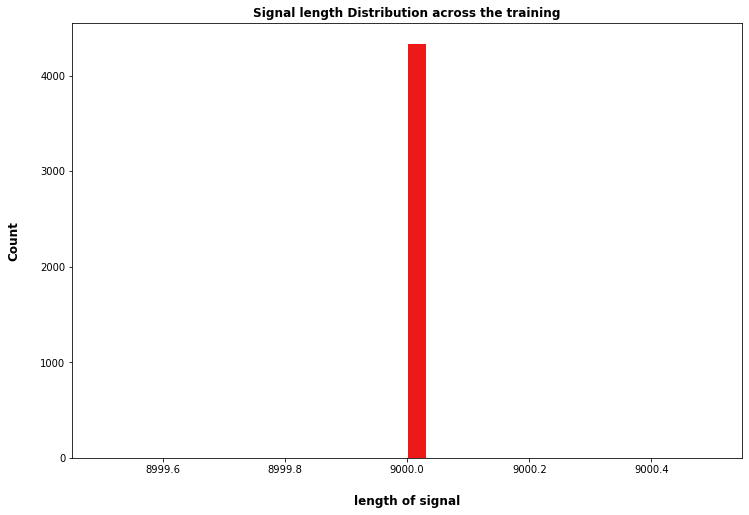

In [ ]:
train_normalised_aug.signal_length = train_normalised_aug.signal_length.astype(int)

ax = train_normalised_aug.hist(column = 'signal_length', bins = 30, 
                                     grid = False, figsize = (12,8), 
                                     color = '#ed1818', rwidth = 0.9)

ax = ax[0]
for x in ax:

    x.get_xaxis().get_major_formatter().set_useOffset(False)
    x.set_title("Signal length Distribution across the training", weight='bold', size=12)
    x.set_xlabel("length of signal", labelpad=20, weight='bold', size=12)
    x.set_ylabel("Count", labelpad=20, weight='bold', size=12)


In [ ]:
# saving training_normalised and testing_normalised dataframes
pd.to_pickle(train_normalised_aug, "Dataframes/Train_normalised_aug.pkl")

# Preparing all the datasets for using in models 

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Galenband Project

/content/drive/MyDrive/Colab Notebooks/Galenband Project


In [ ]:
# loading the saved dataframe
train_normalised = pd.read_pickle('Dataframes/Train_normalised.pkl')
train_normalised_aug = pd.read_pickle('Dataframes/Train_normalised_aug.pkl')
test_normalised = pd.read_pickle('Dataframes/Test_normalised.pkl')

Preparing both normal and augmented training set with oversampling 

Normal training set oversampling

In [ ]:
# oversampling --- try

# add all the normal instances
train_normalised_oversampled = train_normalised[train_normalised.output_label == 'N']

# create temp df with Afib signals repeated 6 times --- oversampling
temp = train_normalised[train_normalised.output_label == 'A']
temp = pd.concat([temp]*6)

# add all the AFib instance
train_normalised_oversampled = train_normalised_oversampled.append(temp)

# shuffle and reset index
train_normalised_oversampled = train_normalised_oversampled.sample(frac=1).reset_index(drop=True)
# ECG_normalised_oversampled.reset_index(drop=True, inplace=True)

train_normalised_oversampled

,filename,signal_length,signals,output_label
0,A05610,9000,"[[-6, -4, -2, -1, 0, 1, 4, 7, 10, 13, 16, 19, ...",N
1,A00054,9000,"[[-1697, -2084, -2491, -2902, -3273, -3569, -3...",A
2,A05218_b,9000,"[[212, 218, 224, 228, 230, 233, 235, 237, 240,...",N
3,A00972_b,9000,"[[-18, -16, -15, -14, -12, -10, -8, -6, -3, 0,...",A
4,A05059,9000,"[[-126, -156, -189, -227, -262, -284, -296, -3...",A
...,...,...,...,...
6550,A06656,9000,"[[33, 36, 41, 46, 51, 57, 63, 69, 74, 78, 80, ...",N
6551,A02900,9000,"[[-169, -184, -220, -269, -326, -382, -409, -4...",A
6552,A02727,9000,"[[-118, -125, -134, -143, -144, -133, -97, -56...",A
6553,A01267,9000,"[[-30, -32, -34, -38, -42, -47, -52, -57, -61,...",A


In [ ]:
train_normalised_oversampled['output_label'].value_counts()

N    3459
A    3096
Name: output_label, dtype: int64

Augmented training set oversampling

In [ ]:
# oversampling --- try

# add all the normal instances
train_normalised_oversampled_aug = train_normalised_aug[train_normalised_aug.output_label == 'N']

# create temp df with Afib signals repeated 7 times --- oversampling
temp = train_normalised_aug[train_normalised_aug.output_label == 'A']
temp = pd.concat([temp]*6)

# add all the AFib instance
train_normalised_oversampled_aug = train_normalised_oversampled_aug.append(temp)

# shuffle and reset index
train_normalised_oversampled_aug = train_normalised_oversampled_aug.sample(frac=1).reset_index(drop=True)
# ECG_normalised_oversampled.reset_index(drop=True, inplace=True)

train_normalised_oversampled_aug

In [ ]:
train_normalised_oversampled_aug['output_label'].value_counts()

N    3796
A    3228
Name: output_label, dtype: int64

In [ ]:
# saving training_normalised_oversampled and train_normalised_oversampled_aug
pd.to_pickle(train_normalised_oversampled, "Dataframes/train_normalised_oversampled.pkl")
pd.to_pickle(train_normalised_oversampled_aug, "Dataframes/train_normalised_aug_oversampled.pkl")

# Preprocessing Galenband data

## Loading ECG data

Normal files

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Galenband Project/Data/galenband/ECG/Normal

/content/drive/MyDrive/Colab Notebooks/Galenband Project/Data/galenband/ECG/Normal


In [ ]:
# listing all the files present in the directory
dir_files = os.listdir('.')

In [ ]:
# filtering all the .csv files -- This contains the ECG signals
galenband_ECG = pd.DataFrame(columns = ['File_name', 'Signal_length', 'Signal', 'Class'])

for file in dir_files:
  file_name   = file.split('.')[0]
  signal      = genfromtxt(file, delimiter=',')
  signal_len  = len(signal)
  output      = 'N'

  galenband_ECG = galenband_ECG.append({'File_name' : file_name, 
                                        'Signal_length' : signal_len, 
                                        'Signal' : signal, 
                                        'Class' : output}, ignore_index = True)

In [ ]:
galenband_ECG

,File_name,Signal_length,Signal,Class
0,ECG_Unit3_aligned,2465263,"[0.00199134823364136, 0.0674724104838396, 0.14...",N
1,ECG_Unit01_aligned,2993128,"[0.0385398788510962, 0.0679520633823335, 0.098...",N
2,ECG_Unit04_aligned,3465847,"[0.0, 0.00414805119388036, 0.00400267601978242...",N
3,ECG_Unit17_aligned,3777543,"[-0.0587547629801727, -0.0600401402967363, -0....",N
4,ECG_Unit14_aligned,3416602,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",N
5,ECG_Unit16_aligned,3349301,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",N
6,ECG_Unit19_aligned,3540853,"[-0.043868306348251, -0.0436690326227174, -0.0...",N
7,ECG_Unit0101_aligned,3318523,"[0.0716096754545913, 0.0712342212834254, 0.070...",N
8,ECG_Unit1101_aligned,3450172,"[0.0180146106041316, 0.0169963269678639, 0.016...",N
9,ECG_Unit0102_aligned,3338272,"[0.0591386504150299, 0.057130052619029, 0.0554...",N


AFib files

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Galenband Project/Data/galenband/ECG/AFib

/content/drive/MyDrive/Colab Notebooks/Galenband Project/Data/galenband/ECG/AFib


In [ ]:
# listing all the files present in the directory
dir_files = os.listdir('.')

In [ ]:
for file in dir_files:
  file_name   = file.split('.')[0]
  signal      = genfromtxt(file, delimiter=',')
  signal_len  = len(signal)
  output      = 'A'

  galenband_ECG = galenband_ECG.append({'File_name' : file_name, 
                                        'Signal_length' : signal_len, 
                                        'Signal' : signal, 
                                        'Class' : output}, ignore_index = True)

In [ ]:
galenband_ECG

,File_name,Signal_length,Signal,Class
0,ECG_Unit3_aligned,2465263,"[0.00199134823364136, 0.0674724104838396, 0.14...",N
1,ECG_Unit01_aligned,2993128,"[0.0385398788510962, 0.0679520633823335, 0.098...",N
2,ECG_Unit04_aligned,3465847,"[0.0, 0.00414805119388036, 0.00400267601978242...",N
3,ECG_Unit17_aligned,3777543,"[-0.0587547629801727, -0.0600401402967363, -0....",N
4,ECG_Unit14_aligned,3416602,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",N
5,ECG_Unit16_aligned,3349301,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",N
6,ECG_Unit19_aligned,3540853,"[-0.043868306348251, -0.0436690326227174, -0.0...",N
7,ECG_Unit0101_aligned,3318523,"[0.0716096754545913, 0.0712342212834254, 0.070...",N
8,ECG_Unit1101_aligned,3450172,"[0.0180146106041316, 0.0169963269678639, 0.016...",N
9,ECG_Unit0102_aligned,3338272,"[0.0591386504150299, 0.057130052619029, 0.0554...",N


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Galenband Project

/content/drive/MyDrive/Colab Notebooks/Galenband Project


In [ ]:
# saving Galenband ECG data
pd.to_pickle(galenband_ECG, "Dataframes_1/galenband_ECG.pkl")

In [ ]:
# loading the saved dataframe
galenband_ECG                  = pd.read_pickle('Dataframes_1/galenband_ECG.pkl')

In [ ]:
galenband_ECG

## Loading PPG data

Normal files

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Galenband Project/Data/galenband/PPG/Normal

/content/drive/MyDrive/Colab Notebooks/Galenband Project/Data/galenband/PPG/Normal


In [ ]:
# listing all the files present in the directory
dir_files = os.listdir('.')

In [ ]:
# filtering all the .csv files -- This contains the ECG signals
galenband_PPG = pd.DataFrame(columns = ['File_name', 'Signal_length', 'Signal', 'Class'])

for file in dir_files:
  file_name   = file.split('.')[0]
  signal      = genfromtxt(file, delimiter=',')
  signal_len  = len(signal)
  output      = 'N'

  galenband_PPG = galenband_PPG.append({'File_name' : file_name, 
                                        'Signal_length' : signal_len, 
                                        'Signal' : signal, 
                                        'Class' : output}, ignore_index = True)

In [ ]:
galenband_PPG

,File_name,Signal_length,Signal,Class
0,PPG_Unit3_aligned,2474016,"[0.0, 1659.0, 1659.0, 1658.0, 1660.0, 1661.0, ...",N
1,PPG_Unit01_aligned,3228010,"[1342.0, 1342.0, 1344.0, 1343.0, 1345.0, 1346....",N
2,PPG_Unit04_aligned,3398968,"[1178.0, 1175.0, 1175.0, 1176.0, 1176.0, 1178....",N
3,PPG_Unit17_aligned,3585006,"[0.0, 0.0, 0.0, 0.0, 1021.0, 1022.0, 1023.0, 1...",N
4,PPG_Unit14_aligned,3416932,"[1787.0, 1781.0, 1782.0, 1782.0, 1781.0, 1780....",N
5,PPG_Unit16_aligned,3348876,"[1397.0, 1397.0, 1396.0, 1398.0, 1397.0, 1394....",N
6,PPG_Unit19_aligned,3559763,"[1259.0, 1257.0, 1259.0, 1258.0, 1257.0, 1257....",N
7,PPG_Unit0101_aligned,3319851,"[1292.0, 1290.0, 1292.0, 1290.0, 1288.0, 1291....",N
8,PPG_Unit1101_aligned,3450172,"[1387.0, 1386.0, 1386.0, 1386.0, 1387.0, 1386....",N
9,PPG_Unit0102_aligned,3337902,"[1341.0, 1340.0, 1339.0, 1342.0, 1341.0, 1341....",N


AFib files

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Galenband Project/Data/galenband/PPG/AFib

/content/drive/MyDrive/Colab Notebooks/Galenband Project/Data/galenband/PPG/AFib


In [ ]:
# listing all the files present in the directory
dir_files = os.listdir('.')

In [ ]:
for file in dir_files:
  file_name   = file.split('.')[0]
  signal      = genfromtxt(file, delimiter=',')
  signal_len  = len(signal)
  output      = 'A'

  galenband_PPG = galenband_PPG.append({'File_name' : file_name, 
                                        'Signal_length' : signal_len, 
                                        'Signal' : signal, 
                                        'Class' : output}, ignore_index = True)

In [ ]:
galenband_PPG

,File_name,Signal_length,Signal,Class
0,PPG_Unit3_aligned,2474016,"[0.0, 1659.0, 1659.0, 1658.0, 1660.0, 1661.0, ...",N
1,PPG_Unit01_aligned,3228010,"[1342.0, 1342.0, 1344.0, 1343.0, 1345.0, 1346....",N
2,PPG_Unit04_aligned,3398968,"[1178.0, 1175.0, 1175.0, 1176.0, 1176.0, 1178....",N
3,PPG_Unit17_aligned,3585006,"[0.0, 0.0, 0.0, 0.0, 1021.0, 1022.0, 1023.0, 1...",N
4,PPG_Unit14_aligned,3416932,"[1787.0, 1781.0, 1782.0, 1782.0, 1781.0, 1780....",N
5,PPG_Unit16_aligned,3348876,"[1397.0, 1397.0, 1396.0, 1398.0, 1397.0, 1394....",N
6,PPG_Unit19_aligned,3559763,"[1259.0, 1257.0, 1259.0, 1258.0, 1257.0, 1257....",N
7,PPG_Unit0101_aligned,3319851,"[1292.0, 1290.0, 1292.0, 1290.0, 1288.0, 1291....",N
8,PPG_Unit1101_aligned,3450172,"[1387.0, 1386.0, 1386.0, 1386.0, 1387.0, 1386....",N
9,PPG_Unit0102_aligned,3337902,"[1341.0, 1340.0, 1339.0, 1342.0, 1341.0, 1341....",N


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Galenband Project

/content/drive/MyDrive/Colab Notebooks/Galenband Project


In [ ]:
# saving Galenband ECG data
pd.to_pickle(galenband_PPG, "Dataframes_1/galenband_PPG.pkl")

In [ ]:
# loading the saved dataframe
galenband_PPG  = pd.read_pickle('Dataframes_1/galenband_PPG.pkl')

In [ ]:
galenband_PPG

## Combining ECG and PPG data

In [ ]:
galenband_ECG_PPG = pd.DataFrame(columns = ['File_name', 'ECG_Signal_length', 'ECG_Signal', 'PPG_Signal_length','PPG_Signal', 'Class'])

for index in range(len(galenband_ECG)):

  if((galenband_ECG['File_name'][index].split('_')[1] == galenband_PPG['File_name'][index].split('_')[1]) 
      and 
     (galenband_ECG['Class'][index] == galenband_PPG['Class'][index])):
    
    file_name               =   galenband_ECG['File_name'][index].split('_')[1]
    ECG_Signal_length       =   galenband_ECG['Signal_length'][index]
    ECG_Signal              =   galenband_ECG['Signal'][index]

    PPG_Signal_length       =   galenband_PPG['Signal_length'][index]
    PPG_Signal              =   galenband_PPG['Signal'][index]
    Class                   =   galenband_ECG['Class'][index]
    
    galenband_ECG_PPG       =   galenband_ECG_PPG.append({'File_name'           : file_name,
                                                          'ECG_Signal_length'   : ECG_Signal_length,
                                                          'ECG_Signal'          : ECG_Signal,
                                                          'PPG_Signal_length'   : PPG_Signal_length,
                                                          'PPG_Signal'          : PPG_Signal,
                                                          'Class'               : Class}, ignore_index = True)

In [ ]:
galenband_ECG_PPG

,File_name,ECG_Signal_length,ECG_Signal,PPG_Signal_length,PPG_Signal,Class
0,Unit3,2465263,"[0.00199134823364136, 0.0674724104838396, 0.14...",2474016,"[0.0, 1659.0, 1659.0, 1658.0, 1660.0, 1661.0, ...",N
1,Unit01,2993128,"[0.0385398788510962, 0.0679520633823335, 0.098...",3228010,"[1342.0, 1342.0, 1344.0, 1343.0, 1345.0, 1346....",N
2,Unit04,3465847,"[0.0, 0.00414805119388036, 0.00400267601978242...",3398968,"[1178.0, 1175.0, 1175.0, 1176.0, 1176.0, 1178....",N
3,Unit17,3777543,"[-0.0587547629801727, -0.0600401402967363, -0....",3585006,"[0.0, 0.0, 0.0, 0.0, 1021.0, 1022.0, 1023.0, 1...",N
4,Unit14,3416602,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3416932,"[1787.0, 1781.0, 1782.0, 1782.0, 1781.0, 1780....",N
5,Unit16,3349301,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3348876,"[1397.0, 1397.0, 1396.0, 1398.0, 1397.0, 1394....",N
6,Unit19,3540853,"[-0.043868306348251, -0.0436690326227174, -0.0...",3559763,"[1259.0, 1257.0, 1259.0, 1258.0, 1257.0, 1257....",N
7,Unit0101,3318523,"[0.0716096754545913, 0.0712342212834254, 0.070...",3319851,"[1292.0, 1290.0, 1292.0, 1290.0, 1288.0, 1291....",N
8,Unit1101,3450172,"[0.0180146106041316, 0.0169963269678639, 0.016...",3450172,"[1387.0, 1386.0, 1386.0, 1386.0, 1387.0, 1386....",N
9,Unit0102,3338272,"[0.0591386504150299, 0.057130052619029, 0.0554...",3337902,"[1341.0, 1340.0, 1339.0, 1342.0, 1341.0, 1341....",N


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Galenband Project

/content/drive/MyDrive/Colab Notebooks/Galenband Project


In [ ]:
# saving Galenband ECG data
pd.to_pickle(galenband_ECG_PPG, "Dataframes_1/galenband_ECG_PPG.pkl")

In [ ]:
# loading the saved dataframe
galenband_ECG_PPG  = pd.read_pickle('Dataframes_1/galenband_ECG_PPG.pkl')

In [ ]:
galenband_ECG_PPG

## Splitting ECG data into 30 seconds segment

All the data were sampled at 1000 Hz. Thus when sampling, 30 second segment will have 30k sample points.

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Galenband Project

# loading the saved dataframe
galenband_ECG                  = pd.read_pickle('Dataframes_1/galenband_ECG.pkl')

/content/drive/MyDrive/Colab Notebooks/Galenband Project


In [ ]:
# creating a normalised testing dataframe to hold the final data after the below processing
galenband_ECG_30k_segmented = pd.DataFrame(columns = ['File_name', 'Signal_length', 'Signal', 'Class'])


# adding rows into the new dataframe
for row_index in galenband_ECG.index:

  temp_row = galenband_ECG.iloc[row_index]
  sig = galenband_ECG['Signal'][row_index]
  counter = i = 0

  while(True):
    temp_row['File_name']     = galenband_ECG['File_name'][row_index] + str(counter)
    temp_row['Signal']        = sig[i:(i+30000)]
    temp_row['Signal_length'] = len(temp_row['Signal'])
    temp_row['Class']         = galenband_ECG['Class'][row_index]

    # append the rows into the dataframe
    galenband_ECG_30k_segmented = galenband_ECG_30k_segmented.append(temp_row, ignore_index=True)

    i += 30000
    counter += 1

    if(i >= len(sig)):
      break
  
galenband_ECG_30k_segmented = galenband_ECG_30k_segmented[galenband_ECG_30k_segmented['Signal_length'] == 30000]

In [ ]:
galenband_ECG_30k_segmented.reset_index(drop=True, inplace=True)
galenband_ECG_30k_segmented

,File_name,Signal_length,Signal,Class
0,ECG_Unit3_aligned0,30000,"[0.00199134823364136, 0.0674724104838396, 0.14...",N
1,ECG_Unit3_aligned1,30000,"[0.0747966736328692, 0.0745774173408316, 0.074...",N
2,ECG_Unit3_aligned2,30000,"[-0.0339787292503559, -0.0338345124574405, -0....",N
3,ECG_Unit3_aligned3,30000,"[-0.10063599305511, -0.100129024772086, -0.099...",N
4,ECG_Unit3_aligned4,30000,"[-0.0990683301557944, -0.101166377851583, -0.1...",N
...,...,...,...,...
1985,ECG_Unit06_aligned49,30000,"[0.0806330099179173, 0.0781750512597395, 0.075...",A
1986,ECG_Unit06_aligned50,30000,"[0.40031414626319, 0.39785345690435, 0.3958711...",A
1987,ECG_Unit06_aligned51,30000,"[-0.0511649472271351, -0.0513744278668576, -0....",A
1988,ECG_Unit06_aligned52,30000,"[-0.0151573925282261, -0.0142158563028727, -0....",A


In [ ]:
# saving galenband_ECG_30k_segmented ECG data
pd.to_pickle(galenband_ECG_30k_segmented, "Dataframes_1/galenband_ECG_30k_segmented.pkl")

In [ ]:
# creating a normalised testing dataframe to hold the final data after the below processing
galenband_ECG_9k_segmented = pd.DataFrame(columns = ['File_name', 'Signal_length', 'Signal', 'Class'])


# adding rows into the new dataframe
for row_index in galenband_ECG.index:

  temp_row = galenband_ECG.iloc[row_index]
  sig = galenband_ECG['Signal'][row_index]
  counter = i = 0

  while(True):
    temp_row['File_name']     = galenband_ECG['File_name'][row_index] + str(counter)
    temp_row['Signal']        = sig[i:(i+9000)]
    temp_row['Signal_length'] = len(temp_row['Signal'])
    temp_row['Class']         = galenband_ECG['Class'][row_index]

    # append the rows into the dataframe
    galenband_ECG_9k_segmented = galenband_ECG_9k_segmented.append(temp_row, ignore_index=True)

    i += 9000
    counter += 1

    if(i >= len(sig)):
      break
  
galenband_ECG_9k_segmented = galenband_ECG_9k_segmented[galenband_ECG_9k_segmented['Signal_length'] == 9000]

In [ ]:
galenband_ECG_9k_segmented.reset_index(drop=True, inplace=True)
galenband_ECG_9k_segmented

,File_name,Signal_length,Signal,Class
0,ECG_Unit3_aligned0,9000,"[0.00199134823364136, 0.0674724104838396, 0.14...",N
1,ECG_Unit3_aligned1,9000,"[-0.00239708315136375, -0.00614008460370553, -...",N
2,ECG_Unit3_aligned2,9000,"[0.0058807021818246, 0.00521900538823085, 0.00...",N
3,ECG_Unit3_aligned3,9000,"[0.0103225458495961, 0.0100369635967733, 0.010...",N
4,ECG_Unit3_aligned4,9000,"[-0.040978783390928, -0.0388013463464256, -0.0...",N
...,...,...,...,...
6651,ECG_Unit06_aligned176,9000,"[-0.0260519866408794, -0.0250933821171359, -0....",A
6652,ECG_Unit06_aligned177,9000,"[0.00581476563036633, 0.00450812261621672, 0.0...",A
6653,ECG_Unit06_aligned178,9000,"[0.00129000669215572, 0.00371706913338014, 0.0...",A
6654,ECG_Unit06_aligned179,9000,"[-0.0107029035925597, -0.00578581174620291, -0...",A


In [ ]:
# saving galenband_ECG_9k_segmented ECG data
pd.to_pickle(galenband_ECG_9k_segmented, "Dataframes_1/galenband_ECG_9k_segmented.pkl")

## Splitting PPG data into 30 seconds segment

All the data were sampled at 1000 Hz. Thus when sampling, 30 second segment will have 30k sample points.

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Galenband Project

# loading the saved dataframe
galenband_PPG  = pd.read_pickle('Dataframes_1/galenband_PPG.pkl')

/content/drive/MyDrive/Colab Notebooks/Galenband Project


In [ ]:
# creating a normalised testing dataframe to hold the final data after the below processing
galenband_PPG_30k_segmented = pd.DataFrame(columns = ['File_name', 'Signal_length', 'Signal', 'Class'])


# adding rows into the new dataframe
for row_index in galenband_PPG.index:

  temp_row = galenband_PPG.iloc[row_index]
  sig = galenband_PPG['Signal'][row_index]
  counter = i = 0

  while(True):
    temp_row['File_name']     = galenband_PPG['File_name'][row_index] + str(counter)
    temp_row['Signal']        = sig[i:(i+30000)]
    temp_row['Signal_length'] = len(temp_row['Signal'])
    temp_row['Class']         = galenband_PPG['Class'][row_index]

    # append the rows into the dataframe
    galenband_PPG_30k_segmented = galenband_PPG_30k_segmented.append(temp_row, ignore_index=True)

    i += 30000
    counter += 1

    if(i >= len(sig)):
      break
  
galenband_PPG_30k_segmented = galenband_PPG_30k_segmented[galenband_PPG_30k_segmented['Signal_length'] == 30000]

In [ ]:
galenband_PPG_30k_segmented.reset_index(drop=True, inplace=True)
galenband_PPG_30k_segmented

,File_name,Signal_length,Signal,Class
0,PPG_Unit3_aligned0,30000,"[0.0, 1659.0, 1659.0, 1658.0, 1660.0, 1661.0, ...",N
1,PPG_Unit3_aligned1,30000,"[1301.0, 1301.0, 1301.0, 1301.0, 1301.0, 1299....",N
2,PPG_Unit3_aligned2,30000,"[1270.0, 1273.0, 1275.0, 1270.0, 1274.0, 1269....",N
3,PPG_Unit3_aligned3,30000,"[1474.0, 1473.0, 1471.0, 1471.0, 1469.0, 1468....",N
4,PPG_Unit3_aligned4,30000,"[1471.0, 1469.0, 1468.0, 1466.0, 1465.0, 1466....",N
...,...,...,...,...
1986,PPG_Unit06_aligned49,30000,"[1079.0, 1081.0, 1081.0, 1081.0, 1081.0, 1079....",A
1987,PPG_Unit06_aligned50,30000,"[991.0, 990.0, 992.0, 992.0, 993.0, 990.0, 991...",A
1988,PPG_Unit06_aligned51,30000,"[993.0, 994.0, 991.0, 990.0, 990.0, 989.0, 989...",A
1989,PPG_Unit06_aligned52,30000,"[1291.0, 1294.0, 1301.0, 1306.0, 1314.0, 1317....",A


In [ ]:
# saving galenband_PPG_30k_segmented ECG data
pd.to_pickle(galenband_PPG_30k_segmented, "Dataframes_1/galenband_PPG_30k_segmented.pkl")

In [ ]:
# creating a normalised testing dataframe to hold the final data after the below processing
galenband_PPG_9k_segmented = pd.DataFrame(columns = ['File_name', 'Signal_length', 'Signal', 'Class'])


# adding rows into the new dataframe
for row_index in galenband_PPG.index:

  temp_row = galenband_PPG.iloc[row_index]
  sig = galenband_PPG['Signal'][row_index]
  counter = i = 0

  while(True):
    temp_row['File_name']     = galenband_PPG['File_name'][row_index] + str(counter)
    temp_row['Signal']        = sig[i:(i+9000)]
    temp_row['Signal_length'] = len(temp_row['Signal'])
    temp_row['Class']         = galenband_PPG['Class'][row_index]

    # append the rows into the dataframe
    galenband_PPG_9k_segmented = galenband_PPG_9k_segmented.append(temp_row, ignore_index=True)

    i += 9000
    counter += 1

    if(i >= len(sig)):
      break
  
galenband_PPG_9k_segmented = galenband_PPG_9k_segmented[galenband_PPG_9k_segmented['Signal_length'] == 9000]

In [ ]:
galenband_PPG_9k_segmented.reset_index(drop=True, inplace=True)
galenband_PPG_9k_segmented

,File_name,Signal_length,Signal,Class
0,PPG_Unit3_aligned0,9000,"[0.0, 1659.0, 1659.0, 1658.0, 1660.0, 1661.0, ...",N
1,PPG_Unit3_aligned1,9000,"[1305.0, 1307.0, 1307.0, 1311.0, 1312.0, 1314....",N
2,PPG_Unit3_aligned2,9000,"[1273.0, 1276.0, 1275.0, 1276.0, 1276.0, 1279....",N
3,PPG_Unit3_aligned3,9000,"[1332.0, 1333.0, 1331.0, 1331.0, 1330.0, 1332....",N
4,PPG_Unit3_aligned4,9000,"[1239.0, 1241.0, 1241.0, 1240.0, 1240.0, 1240....",N
...,...,...,...,...
6654,PPG_Unit06_aligned176,9000,"[1685.0, 1684.0, 1682.0, 1684.0, 1685.0, 1683....",A
6655,PPG_Unit06_aligned177,9000,"[1431.0, 1440.0, 1441.0, 1447.0, 1451.0, 1456....",A
6656,PPG_Unit06_aligned178,9000,"[2076.0, 2073.0, 2068.0, 2068.0, 2063.0, 2059....",A
6657,PPG_Unit06_aligned179,9000,"[925.0, 929.0, 929.0, 933.0, 938.0, 938.0, 941...",A


In [ ]:
# saving galenband_PPG_9k_segmented ECG data
pd.to_pickle(galenband_PPG_9k_segmented, "Dataframes_1/galenband_PPG_9k_segmented.pkl")

## Splitting Combined data into 30 seconds segment


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Galenband Project

# loading the saved dataframe
galenband_ECG_PPG  = pd.read_pickle('Dataframes_1/galenband_ECG_PPG.pkl')

/content/drive/MyDrive/Colab Notebooks/Galenband Project


In [ ]:
# creating a normalised testing dataframe to hold the final data after the below processing
galenband_ECG_PPG_30k_segmented = pd.DataFrame(columns = ['File_name', 'ECG_Signal_length', 'ECG_Signal', 
                                                          'PPG_Signal_length','PPG_Signal', 'Class'])


# adding rows into the new dataframe
for row_index in galenband_ECG_PPG.index:

  temp_row = galenband_ECG_PPG.iloc[row_index]
  ECG_sig = galenband_ECG_PPG['ECG_Signal'][row_index]
  PPG_sig = galenband_ECG_PPG['PPG_Signal'][row_index]
  counter = i = 0

  while(True):
    temp_row['File_name']           = galenband_ECG_PPG['File_name'][row_index] + str(counter)
    temp_row['ECG_Signal']          = ECG_sig[i:(i+30000)]
    temp_row['ECG_Signal_length']   = len(temp_row['ECG_Signal'])

    temp_row['PPG_Signal']          = PPG_sig[i:(i+30000)]
    temp_row['PPG_Signal_length']   = len(temp_row['PPG_Signal'])
    temp_row['Class']               = galenband_ECG_PPG['Class'][row_index]

    # append the rows into the dataframe
    galenband_ECG_PPG_30k_segmented = galenband_ECG_PPG_30k_segmented.append(temp_row, ignore_index=True)

    i += 30000
    counter += 1

    if((i >= len(ECG_sig)) or (i >= len(PPG_sig))):
      break

galenband_ECG_PPG_30k_segmented = galenband_ECG_PPG_30k_segmented[(galenband_ECG_PPG_30k_segmented['ECG_Signal_length'] == 30000) &
                                                                  (galenband_ECG_PPG_30k_segmented['PPG_Signal_length'] == 30000)]

In [ ]:
galenband_ECG_PPG_30k_segmented.reset_index(drop=True, inplace=True)
galenband_ECG_PPG_30k_segmented

,File_name,ECG_Signal_length,ECG_Signal,PPG_Signal_length,PPG_Signal,Class
0,Unit30,30000,"[0.00199134823364136, 0.0674724104838396, 0.14...",30000,"[0.0, 1659.0, 1659.0, 1658.0, 1660.0, 1661.0, ...",N
1,Unit31,30000,"[0.0747966736328692, 0.0745774173408316, 0.074...",30000,"[1301.0, 1301.0, 1301.0, 1301.0, 1301.0, 1299....",N
2,Unit32,30000,"[-0.0339787292503559, -0.0338345124574405, -0....",30000,"[1270.0, 1273.0, 1275.0, 1270.0, 1274.0, 1269....",N
3,Unit33,30000,"[-0.10063599305511, -0.100129024772086, -0.099...",30000,"[1474.0, 1473.0, 1471.0, 1471.0, 1469.0, 1468....",N
4,Unit34,30000,"[-0.0990683301557944, -0.101166377851583, -0.1...",30000,"[1471.0, 1469.0, 1468.0, 1466.0, 1465.0, 1466....",N
...,...,...,...,...,...,...
1977,Unit0649,30000,"[0.0806330099179173, 0.0781750512597395, 0.075...",30000,"[1079.0, 1081.0, 1081.0, 1081.0, 1081.0, 1079....",A
1978,Unit0650,30000,"[0.40031414626319, 0.39785345690435, 0.3958711...",30000,"[991.0, 990.0, 992.0, 992.0, 993.0, 990.0, 991...",A
1979,Unit0651,30000,"[-0.0511649472271351, -0.0513744278668576, -0....",30000,"[993.0, 994.0, 991.0, 990.0, 990.0, 989.0, 989...",A
1980,Unit0652,30000,"[-0.0151573925282261, -0.0142158563028727, -0....",30000,"[1291.0, 1294.0, 1301.0, 1306.0, 1314.0, 1317....",A


In [ ]:
# saving galenband_PPG_30k_segmented ECG data
pd.to_pickle(galenband_ECG_PPG_30k_segmented, "Dataframes_1/galenband_ECG_PPG_30k_segmented.pkl")

In [ ]:
## 9k segment

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Galenband Project

# loading the saved dataframe
galenband_ECG_PPG  = pd.read_pickle('Dataframes_1/galenband_ECG_PPG.pkl')

/content/drive/MyDrive/Colab Notebooks/Galenband Project


In [ ]:
# creating a normalised testing dataframe to hold the final data after the below processing
galenband_ECG_PPG_9k_segmented = pd.DataFrame(columns = ['File_name', 'ECG_Signal_length', 'ECG_Signal', 
                                                          'PPG_Signal_length','PPG_Signal', 'Class'])


# adding rows into the new dataframe
for row_index in galenband_ECG_PPG.index:

  temp_row = galenband_ECG_PPG.iloc[row_index]
  ECG_sig = galenband_ECG_PPG['ECG_Signal'][row_index]
  PPG_sig = galenband_ECG_PPG['PPG_Signal'][row_index]
  counter = i = 0

  while(True):
    temp_row['File_name']           = galenband_ECG_PPG['File_name'][row_index] + str(counter)
    temp_row['ECG_Signal']          = ECG_sig[i:(i+9000)]
    temp_row['ECG_Signal_length']   = len(temp_row['ECG_Signal'])

    temp_row['PPG_Signal']          = PPG_sig[i:(i+9000)]
    temp_row['PPG_Signal_length']   = len(temp_row['PPG_Signal'])
    temp_row['Class']               = galenband_ECG_PPG['Class'][row_index]

    # append the rows into the dataframe
    galenband_ECG_PPG_9k_segmented = galenband_ECG_PPG_9k_segmented.append(temp_row, ignore_index=True)

    i += 9000
    counter += 1

    if((i >= len(ECG_sig)) or (i >= len(PPG_sig))):
      break

galenband_ECG_PPG_9k_segmented = galenband_ECG_PPG_9k_segmented[(galenband_ECG_PPG_9k_segmented['ECG_Signal_length'] == 9000) &
                                                                  (galenband_ECG_PPG_9k_segmented['PPG_Signal_length'] == 9000)]

In [ ]:
galenband_ECG_PPG_9k_segmented.reset_index(drop=True, inplace=True)
galenband_ECG_PPG_9k_segmented

,File_name,ECG_Signal_length,ECG_Signal,PPG_Signal_length,PPG_Signal,Class
0,Unit30,9000,"[0.00199134823364136, 0.0674724104838396, 0.14...",9000,"[0.0, 1659.0, 1659.0, 1658.0, 1660.0, 1661.0, ...",N
1,Unit31,9000,"[-0.00239708315136375, -0.00614008460370553, -...",9000,"[1305.0, 1307.0, 1307.0, 1311.0, 1312.0, 1314....",N
2,Unit32,9000,"[0.0058807021818246, 0.00521900538823085, 0.00...",9000,"[1273.0, 1276.0, 1275.0, 1276.0, 1276.0, 1279....",N
3,Unit33,9000,"[0.0103225458495961, 0.0100369635967733, 0.010...",9000,"[1332.0, 1333.0, 1331.0, 1331.0, 1330.0, 1332....",N
4,Unit34,9000,"[-0.040978783390928, -0.0388013463464256, -0.0...",9000,"[1239.0, 1241.0, 1241.0, 1240.0, 1240.0, 1240....",N
...,...,...,...,...,...,...
6621,Unit06176,9000,"[-0.0260519866408794, -0.0250933821171359, -0....",9000,"[1685.0, 1684.0, 1682.0, 1684.0, 1685.0, 1683....",A
6622,Unit06177,9000,"[0.00581476563036633, 0.00450812261621672, 0.0...",9000,"[1431.0, 1440.0, 1441.0, 1447.0, 1451.0, 1456....",A
6623,Unit06178,9000,"[0.00129000669215572, 0.00371706913338014, 0.0...",9000,"[2076.0, 2073.0, 2068.0, 2068.0, 2063.0, 2059....",A
6624,Unit06179,9000,"[-0.0107029035925597, -0.00578581174620291, -0...",9000,"[925.0, 929.0, 929.0, 933.0, 938.0, 938.0, 941...",A


In [ ]:
# saving galenband_PPG_30k_segmented ECG data
pd.to_pickle(galenband_ECG_PPG_9k_segmented, "Dataframes_1/galenband_ECG_PPG_9k_segmented.pkl")

## Denoising the ECG dataset


In [ ]:
# loading the saved dataframe
%cd /content/drive/MyDrive/Colab Notebooks/Galenband Project

# Original Data
galenband_ECG_30k_segmented               = pd.read_pickle('Dataframes_1/galenband_ECG_30k_segmented.pkl')
# galenband__9k_segmented                = pd.read_pickle('Dataframes_1/galenband_PPG_9k_segmented.pkl')

/content/drive/MyDrive/Colab Notebooks/Galenband Project


### 1. Sample function

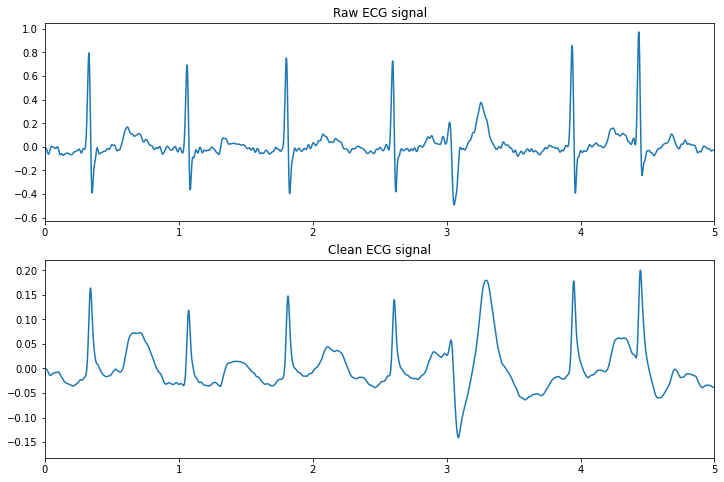

In [ ]:
## A high pass filter allows frequencies higher than a cut-off value
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5*fs
    normal_cutoff = cutoff/nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False, output='ba')
    return b, a

## A low pass filter allows frequencies lower than a cut-off value
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5*fs
    normal_cutoff = cutoff/nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False, output='ba')
    return b, a

def notch_filter(cutoff, q):
    nyq = 0.5*fs
    freq = cutoff/nyq
    b, a = iirnotch(freq, q)
    return b, a

def highpass(data, fs, order=5):
    b,a = butter_highpass(cutoff_high, fs, order=order)
    x = lfilter(b,a,data)
    return x

def lowpass(data, fs, order =5):
    b,a = butter_lowpass(cutoff_low, fs, order=order)
    y = lfilter(b,a,data)
    return y

def notch(data, powerline, q):
    b,a = notch_filter(powerline,q)
    z = lfilter(b,a,data)
    return z

def final_filter(data, fs, order=5):
    b, a = butter_highpass(cutoff_high, fs, order=order)
    x = lfilter(b, a, data)
    d, c = butter_lowpass(cutoff_low, fs, order = order)
    y = lfilter(d, c, x)
    f, e = notch_filter(powerline, 30)
    z = lfilter(f, e, y)     
    return z

ecg_signal =  galenband_ECG_30k_segmented['Signal'][1000]
fs = 1000
time = np.arange(ecg_signal.size) / fs

## Order of five works well with ECG signals
cutoff_high = 0.5
cutoff_low = 2
powerline = 60
order = 1

plt.figure(1, figsize=(12,8))
ax1 = plt.subplot(211)
plt.plot(time, ecg_signal)
ax1.set_title("Raw ECG signal")
ax1.axis(xmin = 0 , xmax = 5)


filter_signal = final_filter(ecg_signal, fs, order)
ax2 = plt.subplot(212)
plt.plot(time, filter_signal)
ax2.set_title("Clean ECG signal")
ax2.axis(xmin = 0 , xmax = 5)
plt.show()

### 2. sample baseline wander

In [ ]:
!pip install heartpy
import heartpy as hp

     |████████████████████████████████| 1.0 MB 5.1 MB/s 


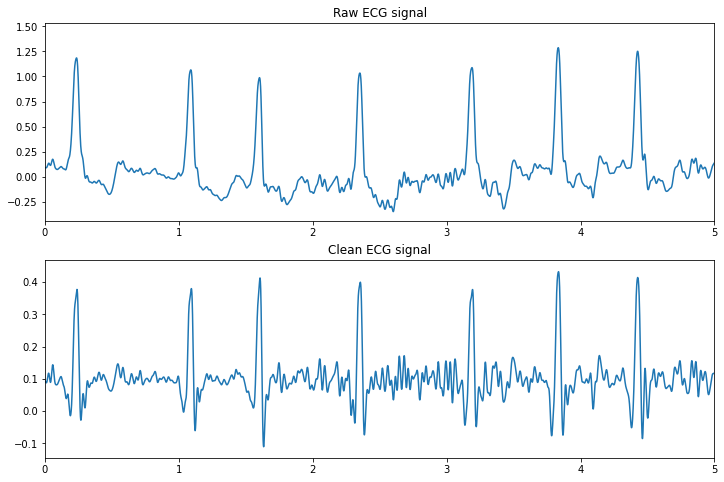

In [ ]:
sample_rate = 1000

def filter_and_visualise(data, sample_rate):
    '''
    function that filters using remove_baseline_wander 
    and visualises result
    '''

    time = np.arange(ecg_signal.size) / sample_rate

    filtered = hp.remove_baseline_wander(data, sample_rate)
    
    plt.figure(1, figsize=(12,8))
    ax1 = plt.subplot(211)
    plt.plot(time, data)
    ax1.set_title("Raw ECG signal")
    ax1.axis(xmin = 0 , xmax = 5)


    ax2 = plt.subplot(212)
    plt.plot(time, filtered)
    ax2.set_title("Clean ECG signal")
    ax2.axis(xmin = 0 , xmax = 5)
    plt.show()


    

    # plt.figure(figsize=(12,3))
    # plt.title('signal with baseline wander removed')
    # plt.plot(filtered)
    # plt.show()

    #And let's plot both original and filtered signal, and zoom in to show peaks are not moved
    #We'll also scale both signals with hp.scale_data
    #This is so that they have the same amplitude so that the overlap is better visible
    # plt.figure(figsize=(12,3))
    # plt.title('zoomed in signal with baseline wander removed, original signal overlaid')
    # plt.plot(hp.scale_data(data[200:1200]))
    # plt.plot(hp.scale_data(filtered[200:1200]))
    # plt.show()
    
    return filtered

filtered = filter_and_visualise(galenband_ECG_30k_segmented['Signal'][850], sample_rate)

In [ ]:
galenband_ECG_30k_segmented['Class'][850]

'A'

### 3. sample butterworth filter

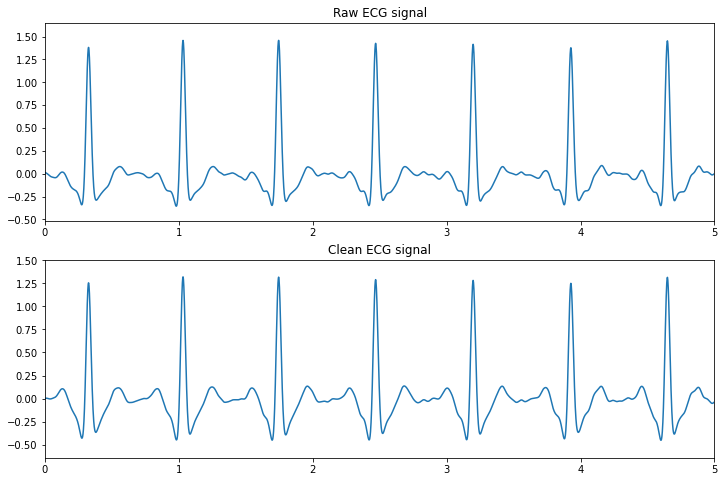

In [ ]:
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt


sample_rate = 1000

def filter_and_visualise(data, sample_rate):
    '''
    function that filters using remove_baseline_wander 
    and visualises result
    '''

    time = np.arange(len(data))/sample_rate

    # apply a 3-pole lowpass filter at 0.1x Nyquist frequency   2, [.003, .03], 4, [.006, .12]
    b, a = scipy.signal.butter(4, [.006, .12], 'band')
    filtered = scipy.signal.filtfilt(b, a, data)

    plt.figure(1, figsize=(12,8))
    ax1 = plt.subplot(211)
    plt.plot(time, data)
    ax1.set_title("Raw ECG signal")
    ax1.axis(xmin = 0 , xmax = 5)


    ax2 = plt.subplot(212)
    plt.plot(time, filtered)
    ax2.set_title("Clean ECG signal")
    ax2.axis(xmin = 0 , xmax = 5)
    plt.show()

   
    return filtered

filtered = filter_and_visualise(galenband_ECG_30k_segmented['Signal'][16], sample_rate)

### Dataset 1 - All original data points

In [ ]:
# Dataset 1 -- All original data points
# galenband_ECG_30k_segmented
# galenband_ECG_9k_segmented

### Dataset 2 -- Butterworth filter on Afib data

In [ ]:
# Dataset 2 -- Butterworth filter on Afib data
# 30k segment
galenband_ECG_30k_segmented.reset_index(drop=True, inplace=True)

galenband_ECG_30k_segmented_butter_afib = pd.DataFrame(columns = ['File_name', 'Signal_length', 'Signal', 'Class'])

# adding rows into the new dataframe
for row_index in galenband_ECG_30k_segmented.index:

  if (galenband_ECG_30k_segmented['Class'][row_index] == 'N'):
    galenband_ECG_30k_segmented_butter_afib = galenband_ECG_30k_segmented_butter_afib.append(galenband_ECG_30k_segmented.iloc[row_index], ignore_index=True)

  else:
    sig = galenband_ECG_30k_segmented['Signal'][row_index]

    b, a = scipy.signal.butter(3, [.01, .05], 'band')    # 3rd ordered filter with low pass and hish pass frequency
                                                         # For a Butterworth filter, this is the point at which the
                                                         # gain drops to 1/sqrt(2) that of the passband (the “-3 dB point”). 
    filtered = scipy.signal.filtfilt(b, a, sig)
    
    temp_row = galenband_ECG_30k_segmented.iloc[row_index]
    temp_row['Signal']        = filtered
    
    # append the rows into the dataframe
    galenband_ECG_30k_segmented_butter_afib = galenband_ECG_30k_segmented_butter_afib.append(temp_row, ignore_index=True)


# 9k segment
galenband_ECG_9k_segmented.reset_index(drop=True, inplace=True)
galenband_ECG_9k_segmented_butter_afib = pd.DataFrame(columns = ['File_name', 'Signal_length', 'Signal', 'Class'])

# adding rows into the new dataframe
for row_index in galenband_ECG_9k_segmented.index:

  if (galenband_ECG_9k_segmented['Class'][row_index] == 'N'):
    galenband_ECG_9k_segmented_butter_afib = galenband_ECG_9k_segmented_butter_afib.append(galenband_ECG_9k_segmented.iloc[row_index], ignore_index=True)

  else:
    sig = galenband_ECG_9k_segmented['Signal'][row_index]

    b, a = scipy.signal.butter(3, [.01, .05], 'band')
    filtered = scipy.signal.filtfilt(b, a, sig)
    
    temp_row = galenband_ECG_9k_segmented.iloc[row_index]
    temp_row['Signal']        = filtered
    
    # append the rows into the dataframe
    galenband_ECG_9k_segmented_butter_afib = galenband_ECG_9k_segmented_butter_afib.append(temp_row, ignore_index=True)

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Galenband Project

# saving galenband_ECG_9k_segmented ECG data
pd.to_pickle(galenband_ECG_30k_segmented_butter_afib, "Dataframes/galenband_ECG_30k_segmented_butter_afib.pkl")
pd.to_pickle(galenband_ECG_9k_segmented_butter_afib, "Dataframes/galenband_ECG_9k_segmented_butter_afib.pkl")

/content/drive/MyDrive/Colab Notebooks/Galenband Project


### Dataset 3 -- Butterworth filter on All data

In [ ]:
# Dataset 3 -- Butterworth filter on All data
# 30k segment
galenband_ECG_30k_segmented.reset_index(drop=True, inplace=True)

galenband_ECG_30k_segmented_butter = pd.DataFrame(columns = ['File_name', 'Signal_length', 'Signal', 'Class'])

# adding rows into the new dataframe
for row_index in galenband_ECG_30k_segmented.index:

  sig = galenband_ECG_30k_segmented['Signal'][row_index]

  b, a = scipy.signal.butter(2, [.003, .03], 'band')
  filtered = scipy.signal.filtfilt(b, a, sig)
    
  temp_row = galenband_ECG_30k_segmented.iloc[row_index]
  temp_row['Signal']        = filtered
    
  # append the rows into the dataframe
  galenband_ECG_30k_segmented_butter = galenband_ECG_30k_segmented_butter.append(temp_row, ignore_index=True)


# # 9k segment
# galenband_ECG_9k_segmented.reset_index(drop=True, inplace=True)
# galenband_ECG_9k_segmented_butter = pd.DataFrame(columns = ['File_name', 'Signal_length', 'Signal', 'Class'])

# # adding rows into the new dataframe
# for row_index in galenband_ECG_9k_segmented.index:

#   sig = galenband_ECG_9k_segmented['Signal'][row_index]

#   b, a = scipy.signal.butter(3, [.01, .05], 'band')
#   filtered = scipy.signal.filtfilt(b, a, sig)
    
#   temp_row = galenband_ECG_9k_segmented.iloc[row_index]
#   temp_row['Signal']        = filtered
    
#   # append the rows into the dataframe
#   galenband_ECG_9k_segmented_butter = galenband_ECG_9k_segmented_butter.append(temp_row, ignore_index=True)

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Galenband Project

# saving galenband_ECG_9k_segmented ECG data
pd.to_pickle(galenband_ECG_30k_segmented_butter, "Dataframes_1/galenband_ECG_30k_segmented_butter.pkl")
# pd.to_pickle(galenband_ECG_9k_segmented_butter, "Dataframes/galenband_ECG_9k_segmented_butter.pkl")

/content/drive/MyDrive/Colab Notebooks/Galenband Project


### Dataset 4 -- Baseline wander filter on Afib data

In [ ]:
# Dataset 4 -- Baseline wander filter on Afib data
# 30k segment
galenband_ECG_30k_segmented.reset_index(drop=True, inplace=True)

galenband_ECG_30k_segmented_wander_afib = pd.DataFrame(columns = ['File_name', 'Signal_length', 'Signal', 'Class'])

# adding rows into the new dataframe
for row_index in galenband_ECG_30k_segmented.index:

  if (galenband_ECG_30k_segmented['Class'][row_index] == 'N'):
    galenband_ECG_30k_segmented_wander_afib = galenband_ECG_30k_segmented_wander_afib.append(galenband_ECG_30k_segmented.iloc[row_index], ignore_index=True)

  else:
    sig = galenband_ECG_30k_segmented['Signal'][row_index]

    filtered = hp.remove_baseline_wander(sig, 1000)
    
    temp_row = galenband_ECG_30k_segmented.iloc[row_index]
    temp_row['Signal']        = filtered
    
    # append the rows into the dataframe
    galenband_ECG_30k_segmented_wander_afib = galenband_ECG_30k_segmented_wander_afib.append(temp_row, ignore_index=True)


# 9k segment
galenband_ECG_9k_segmented.reset_index(drop=True, inplace=True)
galenband_ECG_9k_segmented_wander_afib = pd.DataFrame(columns = ['File_name', 'Signal_length', 'Signal', 'Class'])

# adding rows into the new dataframe
for row_index in galenband_ECG_9k_segmented.index:

  if (galenband_ECG_9k_segmented['Class'][row_index] == 'N'):
    galenband_ECG_9k_segmented_wander_afib = galenband_ECG_9k_segmented_wander_afib.append(galenband_ECG_9k_segmented.iloc[row_index], ignore_index=True)

  else:
    sig = galenband_ECG_9k_segmented['Signal'][row_index]

    filtered = hp.remove_baseline_wander(sig, 1000)
    
    temp_row = galenband_ECG_9k_segmented.iloc[row_index]
    temp_row['Signal']        = filtered
    
    # append the rows into the dataframe
    galenband_ECG_9k_segmented_wander_afib = galenband_ECG_9k_segmented_wander_afib.append(temp_row, ignore_index=True)

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Galenband Project

# saving galenband_ECG_9k_segmented ECG data
pd.to_pickle(galenband_ECG_30k_segmented_wander_afib, "Dataframes/galenband_ECG_30k_segmented_wander_afib.pkl")
pd.to_pickle(galenband_ECG_9k_segmented_wander_afib, "Dataframes/galenband_ECG_9k_segmented_wander_afib.pkl")

/content/drive/MyDrive/Colab Notebooks/Galenband Project


### Dataset 5 -- Baseline Wander filter on All data

In [ ]:
# Dataset 5 -- Baseline Wander filter on All data
# 30k segment
galenband_ECG_30k_segmented.reset_index(drop=True, inplace=True)

galenband_ECG_30k_segmented_wander = pd.DataFrame(columns = ['File_name', 'Signal_length', 'Signal', 'Class'])

# adding rows into the new dataframe
for row_index in galenband_ECG_30k_segmented.index:

  sig = galenband_ECG_30k_segmented['Signal'][row_index]

  filtered = hp.remove_baseline_wander(sig, 1000)
    
  temp_row = galenband_ECG_30k_segmented.iloc[row_index]
  temp_row['Signal']        = filtered
    
  # append the rows into the dataframe
  galenband_ECG_30k_segmented_wander = galenband_ECG_30k_segmented_wander.append(temp_row, ignore_index=True)


# 9k segment
galenband_ECG_9k_segmented.reset_index(drop=True, inplace=True)
galenband_ECG_9k_segmented_wander = pd.DataFrame(columns = ['File_name', 'Signal_length', 'Signal', 'Class'])

# adding rows into the new dataframe
for row_index in galenband_ECG_9k_segmented.index:

  sig = galenband_ECG_9k_segmented['Signal'][row_index]

  filtered = hp.remove_baseline_wander(sig, 1000)
    
  temp_row = galenband_ECG_9k_segmented.iloc[row_index]
  temp_row['Signal']        = filtered
    
  # append the rows into the dataframe
  galenband_ECG_9k_segmented_wander = galenband_ECG_9k_segmented_wander.append(temp_row, ignore_index=True)

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Galenband Project

# saving galenband_ECG_9k_segmented ECG data
pd.to_pickle(galenband_ECG_30k_segmented_wander, "Dataframes/galenband_ECG_30k_segmented_wander.pkl")
pd.to_pickle(galenband_ECG_9k_segmented_wander, "Dataframes/galenband_ECG_9k_segmented_wander.pkl")

/content/drive/MyDrive/Colab Notebooks/Galenband Project


## Denoising the PPG dataset


In [ ]:
# loading the saved dataframe
%cd /content/drive/MyDrive/Colab Notebooks/Galenband Project

# Original Data
galenband_PPG_30k_segmented               = pd.read_pickle('Dataframes_1/galenband_PPG_30k_segmented.pkl')
galenband_PPG_9k_segmented                = pd.read_pickle('Dataframes_1/galenband_PPG_9k_segmented.pkl')

/content/drive/MyDrive/Colab Notebooks/Galenband Project


In [ ]:
galenband_PPG_30k_segmented

,File_name,Signal_length,Signal,Class
0,PPG_Unit3_aligned0,30000,"[0.0, 1659.0, 1659.0, 1658.0, 1660.0, 1661.0, ...",N
1,PPG_Unit3_aligned1,30000,"[1301.0, 1301.0, 1301.0, 1301.0, 1301.0, 1299....",N
2,PPG_Unit3_aligned2,30000,"[1270.0, 1273.0, 1275.0, 1270.0, 1274.0, 1269....",N
3,PPG_Unit3_aligned3,30000,"[1474.0, 1473.0, 1471.0, 1471.0, 1469.0, 1468....",N
4,PPG_Unit3_aligned4,30000,"[1471.0, 1469.0, 1468.0, 1466.0, 1465.0, 1466....",N
...,...,...,...,...
1986,PPG_Unit06_aligned49,30000,"[1079.0, 1081.0, 1081.0, 1081.0, 1081.0, 1079....",A
1987,PPG_Unit06_aligned50,30000,"[991.0, 990.0, 992.0, 992.0, 993.0, 990.0, 991...",A
1988,PPG_Unit06_aligned51,30000,"[993.0, 994.0, 991.0, 990.0, 990.0, 989.0, 989...",A
1989,PPG_Unit06_aligned52,30000,"[1291.0, 1294.0, 1301.0, 1306.0, 1314.0, 1317....",A


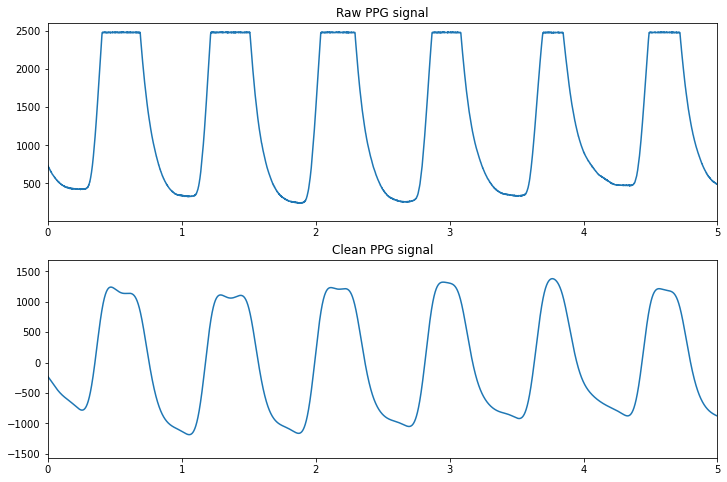

In [ ]:
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt


sample_rate = 1000

def filter_and_visualise(data, sample_rate):
    '''
    function that filters using remove_baseline_wander 
    and visualises result
    '''

    time = np.arange(len(data))/sample_rate

    # apply a 3-pole lowpass filter at 0.1x Nyquist frequency
    fs = 1000
    nyq = 0.5 * fs
    low = 0.5 / nyq
    high = 5 / nyq
    b, a = scipy.signal.butter(2, [low, high], 'band')
    filtered = scipy.signal.filtfilt(b, a, data)

    plt.figure(1, figsize=(12,8))
    ax1 = plt.subplot(211)
    plt.plot(time, data)
    ax1.set_title("Raw PPG signal")
    ax1.axis(xmin = 0 , xmax = 5)


    ax2 = plt.subplot(212)
    plt.plot(time, filtered)
    ax2.set_title("Clean PPG signal")
    ax2.axis(xmin = 0 , xmax = 5)
    plt.show()

   
    return filtered

filtered = filter_and_visualise(galenband_PPG_30k_segmented['Signal'][350], sample_rate)

### Dataset 1. 2nd order Band-Pass Butterworth filters with cut-off freq(0.5 - 5 Hz)

In [ ]:
fs    = 1000
nyq   = 0.5 * fs
low   = 0.5 / nyq
high  = 5 / nyq
order = 2

In [ ]:
# 30k segment
galenband_PPG_30k_segmented.reset_index(drop=True, inplace=True)

galenband_PPG_30k_segmented_butter_2_5_5 = pd.DataFrame(columns = ['File_name', 'Signal_length', 'Signal', 'Class'])

# adding rows into the new dataframe
for row_index in galenband_PPG_30k_segmented.index:

  sig = galenband_PPG_30k_segmented['Signal'][row_index]

  b, a = scipy.signal.butter(order, [low, high], 'band')
  filtered = scipy.signal.filtfilt(b, a, sig)
    
  temp_row = galenband_PPG_30k_segmented.iloc[row_index]
  temp_row['Signal']        = filtered
    
  # append the rows into the dataframe
  galenband_PPG_30k_segmented_butter_2_5_5 = galenband_PPG_30k_segmented_butter_2_5_5.append(temp_row, ignore_index=True)


# 9k segment
galenband_PPG_9k_segmented.reset_index(drop=True, inplace=True)
galenband_PPG_9k_segmented_butter_2_5_5 = pd.DataFrame(columns = ['File_name', 'Signal_length', 'Signal', 'Class'])

# adding rows into the new dataframe
for row_index in galenband_PPG_9k_segmented.index:

  sig = galenband_PPG_9k_segmented['Signal'][row_index]
  

  b, a = scipy.signal.butter(order, [low, high], 'band')
  filtered = scipy.signal.filtfilt(b, a, sig)
    
  temp_row = galenband_PPG_9k_segmented.iloc[row_index]
  temp_row['Signal']        = filtered
    
  # append the rows into the dataframe
  galenband_PPG_9k_segmented_butter_2_5_5 = galenband_PPG_9k_segmented_butter_2_5_5.append(temp_row, ignore_index=True)

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Galenband Project

# saving galenband_PPG_9k_segmented ECG data
pd.to_pickle(galenband_PPG_30k_segmented_butter_2_5_5, "Dataframes_1/galenband_PPG_30k_segmented_butter_2_5_5.pkl")
pd.to_pickle(galenband_PPG_9k_segmented_butter_2_5_5, "Dataframes_1/galenband_PPG_9k_segmented_butter_2_5_5.pkl")

/content/drive/MyDrive/Colab Notebooks/Galenband Project


### Dataset 2. 4th order Band-Pass Butterworth filters with cut-off freq(1 - 18 Hz)

In [ ]:
fs    = 1000
nyq   = 0.5 * fs
low   = 1 / nyq
high  = 18 / nyq
order = 4

In [ ]:
# 30k segment
galenband_PPG_30k_segmented.reset_index(drop=True, inplace=True)

galenband_PPG_30k_segmented_butter_4_1_18 = pd.DataFrame(columns = ['File_name', 'Signal_length', 'Signal', 'Class'])

# adding rows into the new dataframe
for row_index in galenband_PPG_30k_segmented.index:

  sig = galenband_PPG_30k_segmented['Signal'][row_index]

  b, a = scipy.signal.butter(order, [low, high], 'band')
  filtered = scipy.signal.filtfilt(b, a, sig)
    
  temp_row = galenband_PPG_30k_segmented.iloc[row_index]
  temp_row['Signal']        = filtered
    
  # append the rows into the dataframe
  galenband_PPG_30k_segmented_butter_4_1_18 = galenband_PPG_30k_segmented_butter_4_1_18.append(temp_row, ignore_index=True)


# 9k segment
galenband_PPG_9k_segmented.reset_index(drop=True, inplace=True)
galenband_PPG_9k_segmented_butter_4_1_18 = pd.DataFrame(columns = ['File_name', 'Signal_length', 'Signal', 'Class'])

# adding rows into the new dataframe
for row_index in galenband_PPG_9k_segmented.index:

  sig = galenband_PPG_9k_segmented['Signal'][row_index]
  

  b, a = scipy.signal.butter(order, [low, high], 'band')
  filtered = scipy.signal.filtfilt(b, a, sig)
    
  temp_row = galenband_PPG_9k_segmented.iloc[row_index]
  temp_row['Signal']        = filtered
    
  # append the rows into the dataframe
  galenband_PPG_9k_segmented_butter_4_1_18 = galenband_PPG_9k_segmented_butter_4_1_18.append(temp_row, ignore_index=True)

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Galenband Project

# saving galenband_PPG_9k_segmented ECG data
pd.to_pickle(galenband_PPG_30k_segmented_butter_4_1_18, "Dataframes_1/galenband_PPG_30k_segmented_butter_4_1_18.pkl")
pd.to_pickle(galenband_PPG_9k_segmented_butter_4_1_18, "Dataframes_1/galenband_PPG_9k_segmented_butter_4_1_18.pkl")

/content/drive/MyDrive/Colab Notebooks/Galenband Project


## Denoising the ECG_PPG dataset


In [ ]:
# loading the saved dataframe
%cd /content/drive/MyDrive/Colab Notebooks/Galenband Project

# Original Data
galenband_ECG_PPG_30k_segmented               = pd.read_pickle('Dataframes_1/galenband_ECG_PPG_30k_segmented.pkl')
galenband_ECG_PPG_9k_segmented                = pd.read_pickle('Dataframes_1/galenband_ECG_PPG_9k_segmented.pkl')

/content/drive/MyDrive/Colab Notebooks/Galenband Project


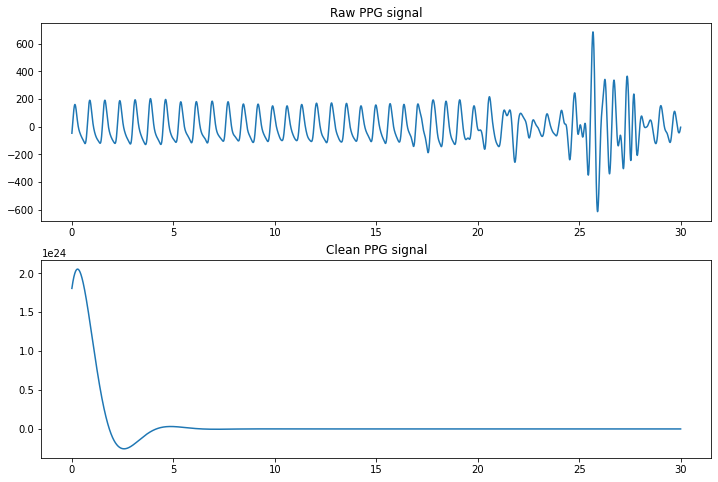

In [ ]:
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt


sample_rate = 1000

def filter_and_visualise(data, sample_rate):
    '''
    function that filters using remove_baseline_wander 
    and visualises result
    '''

    time = np.arange(len(data))/sample_rate

    # apply a 3-pole lowpass filter at 0.1x Nyquist frequency
    fs = 1000
    nyq = 0.5 * fs
    low = 0.1 / nyq
    high = 18 / nyq
    b, a = scipy.signal.butter(4, [low, high], 'band')
    filtered = scipy.signal.filtfilt(b, a, data)

    plt.figure(1, figsize=(12,8))
    ax1 = plt.subplot(211)
    plt.plot(time, data)
    ax1.set_title("Raw PPG signal")
    # ax1.axis(xmin = 0 , xmax = 5)


    ax2 = plt.subplot(212)
    plt.plot(time, filtered)
    ax2.set_title("Clean PPG signal")
    # ax2.axis(xmin = 0 , xmax = 5)
    plt.show()

   
    return filtered

filtered = filter_and_visualise(galenband_PPG_30k_segmented['Signal'][5], sample_rate)

### Dataset 1. 2nd order Band-Pass Butterworth filters with cut-off freq(0.5 - 5 Hz) - both ECG and PPG

In [ ]:
fs    = 1000
nyq   = 0.5 * fs
low   = 0.5 / nyq
high  = 5 / nyq
order = 2

In [ ]:
# 30k segment
galenband_ECG_PPG_30k_segmented.reset_index(drop=True, inplace=True)

galenband_ECG_PPG_30k_segmented_butter_2_5_5 = pd.DataFrame(columns = ['File_name', 'ECG_Signal_length', 'ECG_Signal', 'PPG_Signal_length', 'PPG_Signal', 'Class'])

# adding rows into the new dataframe
for row_index in galenband_ECG_PPG_30k_segmented.index:

  sig_ECG = galenband_ECG_PPG_30k_segmented['ECG_Signal'][row_index]
  sig_PPG = galenband_ECG_PPG_30k_segmented['PPG_Signal'][row_index]

  b, a = scipy.signal.butter(order, [low, high], 'band')
  filtered_ECG = scipy.signal.filtfilt(b, a, sig_ECG)
  filtered_PPG = scipy.signal.filtfilt(b, a, sig_PPG)
    
  temp_row = galenband_ECG_PPG_30k_segmented.iloc[row_index]
  temp_row['ECG_Signal']        = filtered_ECG
  temp_row['PPG_Signal']        = filtered_PPG
    
  # append the rows into the dataframe
  galenband_ECG_PPG_30k_segmented_butter_2_5_5 = galenband_ECG_PPG_30k_segmented_butter_2_5_5.append(temp_row, ignore_index=True)


# 9k segment
galenband_ECG_PPG_9k_segmented.reset_index(drop=True, inplace=True)

galenband_ECG_PPG_9k_segmented_butter_2_5_5 = pd.DataFrame(columns = ['File_name', 'ECG_Signal_length', 'ECG_Signal', 'PPG_Signal_length', 'PPG_Signal', 'Class'])

# adding rows into the new dataframe
for row_index in galenband_ECG_PPG_9k_segmented.index:

  sig_ECG = galenband_ECG_PPG_9k_segmented['ECG_Signal'][row_index]
  sig_PPG = galenband_ECG_PPG_9k_segmented['PPG_Signal'][row_index]

  b, a = scipy.signal.butter(order, [low, high], 'band')
  filtered_ECG = scipy.signal.filtfilt(b, a, sig_ECG)
  filtered_PPG = scipy.signal.filtfilt(b, a, sig_PPG)
    
  temp_row = galenband_ECG_PPG_9k_segmented.iloc[row_index]
  temp_row['ECG_Signal']        = filtered_ECG
  temp_row['PPG_Signal']        = filtered_PPG
    
  # append the rows into the dataframe
  galenband_ECG_PPG_9k_segmented_butter_2_5_5 = galenband_ECG_PPG_9k_segmented_butter_2_5_5.append(temp_row, ignore_index=True)


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Galenband Project

# saving galenband_PPG_9k_segmented ECG data
pd.to_pickle(galenband_ECG_PPG_30k_segmented_butter_2_5_5, "Dataframes_1/galenband_ECG_PPG_30k_segmented_butter_2_5_5.pkl")
pd.to_pickle(galenband_ECG_PPG_9k_segmented_butter_2_5_5, "Dataframes_1/galenband_ECG_PPG_9k_segmented_butter_2_5_5.pkl")

/content/drive/MyDrive/Colab Notebooks/Galenband Project


### Dataset 2. 4th order Band-Pass Butterworth filters with cut-off freq(1 - 18 Hz)

In [ ]:
fs    = 1000
nyq   = 0.5 * fs
low   = 1 / nyq
high  = 18 / nyq
order = 4

In [ ]:
# 30k segment
galenband_ECG_PPG_30k_segmented.reset_index(drop=True, inplace=True)

galenband_ECG_PPG_30k_segmented_butter_4_1_18 = pd.DataFrame(columns = ['File_name', 'ECG_Signal_length', 'ECG_Signal', 'PPG_Signal_length', 'PPG_Signal', 'Class'])

# adding rows into the new dataframe
for row_index in galenband_ECG_PPG_30k_segmented.index:

  sig_ECG = galenband_ECG_PPG_30k_segmented['ECG_Signal'][row_index]
  sig_PPG = galenband_ECG_PPG_30k_segmented['PPG_Signal'][row_index]

  b, a = scipy.signal.butter(order, [low, high], 'band')
  filtered_ECG = scipy.signal.filtfilt(b, a, sig_ECG)
  filtered_PPG = scipy.signal.filtfilt(b, a, sig_PPG)
    
  temp_row = galenband_ECG_PPG_30k_segmented.iloc[row_index]
  temp_row['ECG_Signal']        = filtered_ECG
  temp_row['PPG_Signal']        = filtered_PPG
    
  # append the rows into the dataframe
  galenband_ECG_PPG_30k_segmented_butter_4_1_18 = galenband_ECG_PPG_30k_segmented_butter_4_1_18.append(temp_row, ignore_index=True)


# 9k segment
galenband_ECG_PPG_9k_segmented.reset_index(drop=True, inplace=True)

galenband_ECG_PPG_9k_segmented_butter_4_1_18 = pd.DataFrame(columns = ['File_name', 'ECG_Signal_length', 'ECG_Signal', 'PPG_Signal_length', 'PPG_Signal', 'Class'])

# adding rows into the new dataframe
for row_index in galenband_ECG_PPG_9k_segmented.index:

  sig_ECG = galenband_ECG_PPG_9k_segmented['ECG_Signal'][row_index]
  sig_PPG = galenband_ECG_PPG_9k_segmented['PPG_Signal'][row_index]

  b, a = scipy.signal.butter(order, [low, high], 'band')
  filtered_ECG = scipy.signal.filtfilt(b, a, sig_ECG)
  filtered_PPG = scipy.signal.filtfilt(b, a, sig_PPG)
    
  temp_row = galenband_ECG_PPG_9k_segmented.iloc[row_index]
  temp_row['ECG_Signal']        = filtered_ECG
  temp_row['PPG_Signal']        = filtered_PPG
    
  # append the rows into the dataframe
  galenband_ECG_PPG_9k_segmented_butter_4_1_18 = galenband_ECG_PPG_9k_segmented_butter_4_1_18.append(temp_row, ignore_index=True)


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Galenband Project

# saving galenband_PPG_9k_segmented ECG data
pd.to_pickle(galenband_ECG_PPG_30k_segmented_butter_4_1_18, "Dataframes_1/galenband_ECG_PPG_30k_segmented_butter_4_1_18.pkl")
pd.to_pickle(galenband_ECG_PPG_9k_segmented_butter_4_1_18, "Dataframes_1/galenband_ECG_PPG_9k_segmented_butter_4_1_18.pkl")

/content/drive/MyDrive/Colab Notebooks/Galenband Project
